In [23]:
#data preprocessing
import numpy as np
import pyodbc
import pandas as pd

#ml stuff
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import tensorflow as tf
print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Sequential 
from keras import Input 
from keras.layers import Dense
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import json 
from datetime import datetime 
#utils/visualization
from collections import defaultdict
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle
from ydata_profiling import ProfileReport
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import itertools
import functools
import operator 
from more_itertools import flatten
from collections import Counter
#config vars
pd.options.display.max_columns=100
pd.options.display.max_rows = 1001
pd.options.display.max_seq_items = 10
verbose=1

from sqlalchemy.engine import URL
from sqlalchemy import create_engine

import sqlalchemy as sa
import urllib
from sqlalchemy import *

Tensorflow/Keras: 2.12.0


In [94]:
import mysql.connector
import json
from datetime import datetime

def get_table_results():
    db = mysql.connector.connect(user='admin', password='',
                                host='localhost',
                                database='0006in')

    def custom_serializer(obj):
        if isinstance(obj, datetime):
            return obj.strftime('%Y-%m-%d %H:%M:%S')
        raise TypeError("Type not serializable")

    cursor = db.cursor()
    sql_select_query = f"SELECT * FROM resultslog "

    cursor.execute(sql_select_query,)

    result = cursor.fetchall()

    data_list = []

    data_dict = {}

    for row in result:
        logtime_str = row[0].strftime('%Y-%m-%d %H:%M:%S')
        data_dict[logtime_str] = {
            'Logtime': row[0].strftime('%Y-%m-%d %H:%M:%S'),
            'ValueMandant': row[1],
            'ValueLieferant': row[2],
            'ValueRechnungskopf': row[3]  # Datetime in String umwandeln
        }

    json_data = json.dumps(data_dict, default=custom_serializer)

    return(json_data)


{"2023-07-18 11:32:52": {"Logtime": "2023-07-18 11:32:52", "ValueMandant": "0.9123", "ValueLieferant": "0.9554225601949684", "ValueRechnungskopf": "0.8023862102809471"}, "2023-07-18 11:32:51": {"Logtime": "2023-07-18 11:32:51", "ValueMandant": "0.9123", "ValueLieferant": "0.9123", "ValueRechnungskopf": "0.9123"}, "2023-07-13 11:32:51": {"Logtime": "2023-07-13 11:32:51", "ValueMandant": null, "ValueLieferant": "0.9123", "ValueRechnungskopf": "0.9123"}, "2023-07-13 11:32:50": {"Logtime": "2023-07-13 11:32:50", "ValueMandant": null, "ValueLieferant": "0.9123", "ValueRechnungskopf": null}}


In [93]:
import mysql.connector
from datetime import datetime

def check_if_entry_is_there(logtime, column_name, value_to_enter):
    try:
        db = mysql.connector.connect(user='admin', password='',
                                    host='localhost',
                                    database='0006in')

        cursor = db.cursor()

        # SELECT-Abfrage, um nach dem Eintrag zu suchen
        sql_select_query = f"SELECT {column_name} FROM resultslog WHERE logtime = %s"
        data_to_search = (logtime,)

        # SQL-Abfrage ausführen
        cursor.execute(sql_select_query, data_to_search)

        # Ergebnis abrufen
        result = cursor.fetchone()

        if result is not None:
            # Eintrag vorhanden, Daten zurückgeben
            if result[0] is not None:
                return result[0]
            else:
                # Eintrag in der Spalte fehlt, in die vorhandene Zeile einfügen
                update_query = f"UPDATE resultslog SET {column_name} = %s WHERE logtime = %s"
                data_to_update = (value_to_enter, logtime)

                # SQL-Abfrage ausführen, um den Eintrag zu aktualisieren
                cursor.execute(update_query, data_to_update)

                # Änderungen speichern
                db.commit()

                return value_to_enter

        else:
            # Eintrag nicht vorhanden, neue Zeile mit Logtime erstellen und Eintrag hinzufügen
            sql_insert_query = f"INSERT INTO resultslog (logtime, {column_name}) VALUES (%s, %s)"
            data_to_insert = (logtime, value_to_enter)

            # SQL-Abfrage ausführen, um den neuen Eintrag hinzuzufügen
            cursor.execute(sql_insert_query, data_to_insert)

            # Änderungen speichern
            db.commit()

            return value_to_enter

    except mysql.connector.Error as error:
        # Fehlerbehandlung
        print("Fehler beim Suchen/Hinzufügen des Eintrags: {}".format(error))
        return None

    finally:
        # Verbindung schließen
        cursor.close()
        db.close()

    
check_if_entry_is_there("2023-07-13 11:32:50",  "ValueLieferant", 0.9123)


0.9123

# Connect to Database and get Data

In [51]:
tenant = '0009a5'

In [13]:
def connect_to_db(connection_string,
                    database,
                    driver = 'SQL Server Native Client 11.0',
                    user = 'CCAdmin',
                    password = 'Miw6RjnTGmPHLYF9mG1o'
):
    connection = pyodbc.connect("Driver={"+driver+"};"
                        "Server="+connection_string+";"
                        "Database="+database+";"
                        "uid="+user+";pwd="+password+"")
    return connection

def get_table_data(table_name, connection):
    query = "SELECT * FROM {}".format(table_name)
    df = pd.read_sql_query(query, connection)

    return df

df_table_cclogattributes = get_table_data('CCLogAttributes', connect_to_db(connection_string= 'testclassconprocessingger.database.windows.net', database = 'T_'+tenant+''))
#df_table_cclogdocuments = get_table_data('CCLogDocuments', connect_to_db(database='T_0000xu'))
#df_table_cclogdocuments.to_pickle(df_table_cclogattributes)

#df_table_cclogattributes = df_table_cclogattributes.drop('LogTime', axis=1)
df_table_cclogattributes = df_table_cclogattributes.drop(['Zone','Attribute_DataType','LogTimeTicks'], axis=1)

df_table_cclogattributes = df_table_cclogattributes.replace('\n',' ', regex=True)
df_table_cclogattributes = df_table_cclogattributes.replace('\r',' ', regex=True)
print(len(df_table_cclogattributes.index))

C:\Users\lete\AppData\Local\Temp\ipykernel_12636\12643320.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



11211


In [21]:
def connect_to_db_better(connection_string,
                    database,
                    driver = 'SQL Server Native Client 11.0',
                    user = 'CCAdmin',
                    password = 'Miw6RjnTGmPHLYF9mG1o'
):
    odbc_str = 'DRIVER='+driver+';SERVER='+connection_string+';PORT=1433;UID='+user+';DATABASE='+ database + ';PWD='+ password
    connect_str = 'mssql+pyodbc:///?odbc_connect=' + urllib.parse.quote_plus(odbc_str)

    return connect_str


def get_table_data_CCLOG(table_name, connect_str, startdate, enddate):
    engine = create_engine(connect_str)
    with engine.connect() as conn:
        df = pd.read_sql(text("SELECT * FROM [dbo].["+table_name+"] where LogTime >= "+startdate+" and LogTime <= "+enddate+""), conn)
        return df
    
def get_table_data_CCLOGAUTOTRAIN(table_name, connect_str, startdate, enddate):
    engine = create_engine(connect_str)
    with engine.connect() as conn:
        df = pd.read_sql(text("SELECT * FROM [dbo].["+table_name+"] where CONVERT(datetime2, STOP_TIME, 104) BETWEEN "+startdate+" and "+enddate+""), conn)
        return df

def get_table_data_ALL(table_name, connect_str):
    engine = create_engine(connect_str)
    with engine.connect() as conn:
        df = pd.read_sql(text("SELECT * FROM [dbo].["+table_name+"]"), conn)
        return df
    


In [22]:

def asdfasdf(table_name, connect_str):
    engine = create_engine(connect_str)
    with engine.connect() as conn:
        df = pd.read_sql(text("SELECT * FROM CCLogAttributes"), conn)
        return df
    
df_table_cclogattributes = asdfasdf('CCLogAttributes', connect_to_db_better(connection_string= 'testclassconprocessingger.database.windows.net', database = 'T_'+tenant+''))
df_table_cclogattributes = df_table_cclogattributes.drop(['Zone','Attribute_DataType','LogTimeTicks'], axis=1)

df_table_cclogattributes = df_table_cclogattributes.replace('\n',' ', regex=True)
df_table_cclogattributes = df_table_cclogattributes.replace('\r',' ', regex=True)
print(len(df_table_cclogattributes.index))

11211


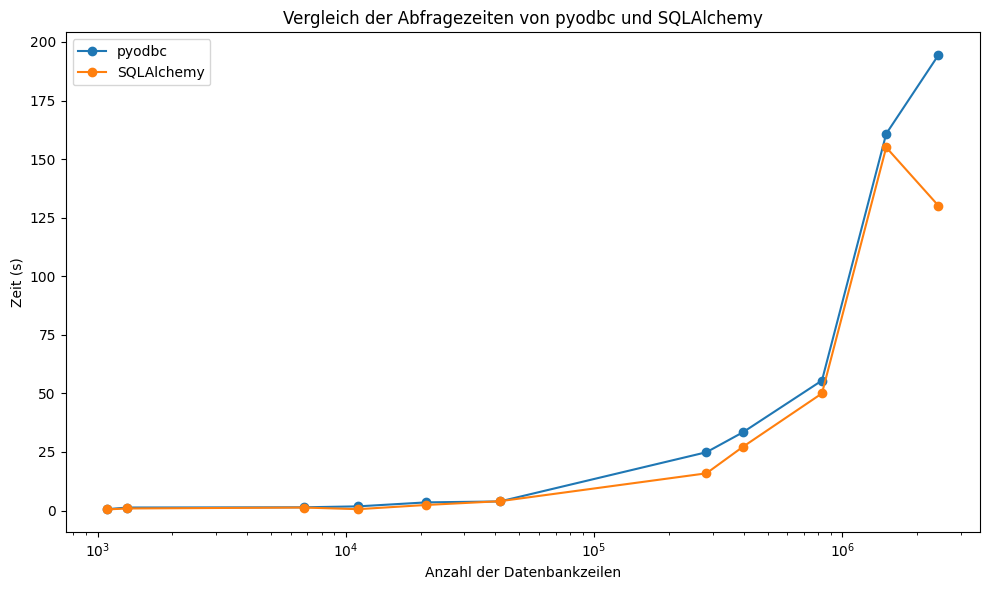

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Beispielwerte
num_columns = [1094, 1317, 6789, 11211, 21122, 41759, 283480, 397515, 827727, 1501985, 2438106]  # Anzahl der Spalten
pyodbc_times = [0.6, 1.3, 1.4, 1.8, 3.5, 3.9, 24.9, 33.4, 55.5, 160.8, 194.4]  # Beispielwerte für pyodbc-Zeiten
sqlalchemy_times = [0.5, 0.9, 1.3, 0.6, 2.4, 4.0, 15.9, 27.2, 50, 155, 130.1]  # Beispielwerte für SQLAlchemy-Zeiten

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.semilogx(num_columns, pyodbc_times, marker='o', label='pyodbc')
plt.semilogx(num_columns, sqlalchemy_times, marker='o', label='SQLAlchemy')
plt.xlabel('Anzahl der Datenbankzeilen')
plt.ylabel('Zeit (s)')
plt.title('Vergleich der Abfragezeiten von pyodbc und SQLAlchemy')
plt.legend()
plt.tight_layout()

# Grafik anzeigen

plt.savefig('abfragezeiten_vergleich.png', dpi=300)


# Data analysis


In [ ]:
#df.head()
#ProfileReport(df)

In [ ]:
dist = df['Delta'].value_counts()
trace = go.Pie(values=(np.array(dist)),labels=dist.index,  pull=[0, 0])
layout = go.Layout(title='Delta Distribution')
data = [trace]
fig = go.Figure(trace,layout)
fig.update_traces(marker=dict(line=dict(color='#000000', width=0.5)), textinfo='value+percent', insidetextorientation='auto')
#sfig.show()

In [ ]:
dist = df['Type'].value_counts()
trace = go.Pie(values=(np.array(dist)),labels=dist.index,  pull=[0, 0.4,0.2,0.1])
layout = go.Layout(title='Type Distribution')
data = [trace]
fig = go.Figure(trace,layout)
fig.update_traces(marker=dict(line=dict(color='#000000', width=0.5)), textinfo='value+percent', insidetextorientation='auto')
#sfig.show()

# Sollerkennungswerte bestimmen


In [4]:
def get_sollwerte(key, df):
    df_ordernum = df.loc[(df['Attribute_Name'] == 'OrderNum')] #&(df['Delta'] == False)
    dist = df_ordernum['Delta'].value_counts(normalize=True)
    print('Kreditor: '+key+'')
    
    try:
        score = 1 - dist.loc[True]
    except:
        score = dist.loc[False]

    print('q(OrderNum): '+str(score)+'') 


    df_ordernum_correct = df.loc[(df['Attribute_Name'] == 'OrderNum') &(df['Delta'] == False)] 
    documentid_list = df_ordernum_correct[['DocumentID']].values.tolist()
    merged = list(itertools.chain.from_iterable(documentid_list))
    denonimator_ordernum = len(documentid_list)
    

    df_debitor_ordernum = df.loc[(df['Attribute_Name'] == 'OrderNum')|(df['Attribute_Name'] == 'DEBITOR_NUM')|(df['Attribute_Name'] == 'VENDOR_NUM')]
    #print(df_debitor_ordernum)
    #df_debitor_ordernum.to_csv('data/debitor_preprocessing.csv', index=False, header= True, encoding='iso-8859-15')
    


    counter_do=0
    counter_vo=0
    for entry_1 in merged:
        speicher_entry_new = df_debitor_ordernum[df_debitor_ordernum.DocumentID == ''.join(str(entry_1))]
        if ((speicher_entry_new.Attribute_Name == 'OrderNum') & (speicher_entry_new.Delta == False)).any(): 
            if ((speicher_entry_new.Attribute_Name == 'DEBITOR_NUM')&(speicher_entry_new.Delta == False)).any():
                    counter_do += 1
            if ((speicher_entry_new.Attribute_Name == 'VENDOR_NUM')&(speicher_entry_new.Delta == False)).any():
                    counter_vo += 1
    try:
        print('q(Mandant|OrderNum): '+str(counter_do/denonimator_ordernum)+'')
        print('q(Vendor|OrderNum): '+str(counter_vo/denonimator_ordernum)+'')
    except:
         print('error')

    counter_vno=0

    df_order_delta = df.loc[(df['Attribute_Name'] == 'OrderNum')&(df['Delta'] == True)]
    df_order_delta_documentid = df_order_delta[['DocumentID']]
    order_delta_list = df_order_delta_documentid.values.tolist()
    order_delta_list_merged = list(itertools.chain.from_iterable(order_delta_list))
    denominator_order_delta_num = len(order_delta_list_merged)


    df_invoicenumber_order_delta = df.loc[(df['Attribute_Name'] == 'DEBITOR_NUM')|(df['Attribute_Name'] == 'OrderNum')]
    for entry_order_delta_invoicenumber in order_delta_list_merged:
        speicher_entry_order_delta = df_invoicenumber_order_delta[df_invoicenumber_order_delta.DocumentID == ''.join(str(entry_order_delta_invoicenumber))]
        if ((speicher_entry_order_delta.Attribute_Name == 'OrderNum') & (speicher_entry_order_delta.Delta == True)).any(): 
            if ((speicher_entry_order_delta.Attribute_Name == 'DEBITOR_NUM') & (speicher_entry_order_delta.Delta == False)).any():
                    counter_vno += 1

    if(counter_vno == 0):
        print('Da keine falsche Ordernum existiert ist Mandant|!Ordernum 0')
    else:
        print('q(Mandant|!OrderNum): '+str(counter_vno/denominator_order_delta_num)+'')
        
    df_vendor_nodelta = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')&(df['Delta'] == False)]
    df_vendor_documentid = df_vendor_nodelta[['DocumentID']]
    vendor_list = df_vendor_documentid.values.tolist()
    vendor_list_merged = list(itertools.chain.from_iterable(vendor_list))
    denominator_vendor_num = len(vendor_list)

    df_invoicenumber_vendor = df.loc[(df['Attribute_Name'] == 'InvoiceNumber')|(df['Attribute_Name'] == 'VENDOR_NUM')|(df['Attribute_Name'] == 'InvoiceDate')|(df['Attribute_Name'] == 'InvoiceDate')|(df['Attribute_Name'] == 'GrossAmount')]

    counter_inv=0
    counter_idv=0
    counter_gv=0

    for entry_vendor_invoicenumber in vendor_list_merged:
        speicher_entry_vendor = df_invoicenumber_vendor[df_invoicenumber_vendor.DocumentID == ''.join(str(entry_vendor_invoicenumber))]
        if ((speicher_entry_vendor.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_vendor.Delta == False)).any(): 
            if ((speicher_entry_vendor.Attribute_Name == 'InvoiceNumber') & (speicher_entry_vendor.Delta == False)).any():
                    counter_inv += 1
            if ((speicher_entry_vendor.Attribute_Name == 'InvoiceDate') & (speicher_entry_vendor.Delta == False)).any():
                    counter_idv += 1
            if ((speicher_entry_vendor.Attribute_Name == 'GrossAmount') & (speicher_entry_vendor.Delta == False)).any():
                    counter_gv += 1

    try:
        print('q(InvoiceNumber|Vendor): '+str(counter_inv/denominator_vendor_num)+'')
        print('q(InvoiceDate|Vendor): '+str(counter_idv/denominator_vendor_num)+'')
        print('q(Gross|Vendor): '+str(counter_gv/denominator_vendor_num)+'')
    except:
        print('error')
    counter_gnv=0

    df_vendor_delta = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')&(df['Delta'] == True)]
    df_vendor_delta_documentid = df_vendor_delta[['DocumentID']]
    vendor_delta_list = df_vendor_delta_documentid.values.tolist()
    vendor_delta_list_merged = list(itertools.chain.from_iterable(vendor_delta_list))
    denominator_vendor_delta_num = len(vendor_delta_list_merged)


    df_invoicenumber_vendor_delta = df.loc[(df['Attribute_Name'] == 'GrossAmount')|(df['Attribute_Name'] == 'VENDOR_NUM')]
    for entry_vendor_delta_invoicenumber in vendor_delta_list_merged:
        speicher_entry_vendor_delta = df_invoicenumber_vendor_delta[df_invoicenumber_vendor_delta.DocumentID == ''.join(str(entry_vendor_delta_invoicenumber))]
        if ((speicher_entry_vendor_delta.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_vendor_delta.Delta == True)).any(): 
            if ((speicher_entry_vendor_delta.Attribute_Name == 'GrossAmount') & (speicher_entry_vendor_delta.Delta == False)).any():
                    counter_gnv += 1

    try:
        print('q(Gross|!Vendor): '+str(counter_gnv/denominator_vendor_delta_num)+'')
    except:
        print('errror')

    counter_vom=0

    df_order_mandant_delta = df.loc[(df['Attribute_Name'] == 'OrderNum')&(df['Delta'] == True)]
    df_order_delta_new = df_order_mandant_delta.loc[(df_order_mandant_delta['Attribute_Name'] == 'Mandant')&(df['Delta'] == False)]
    df_order_delta_mandant_documentid = df_order_delta_new[['DocumentID']]
    order_delta_mandant_list = df_order_delta_mandant_documentid.values.tolist()
    order_delta_mandant_list_merged = list(itertools.chain.from_iterable(order_delta_mandant_list))
    denominator_order_delta_mandant_num = len(order_delta_mandant_list_merged)


    df_invoicenumber_order_delta_mandant = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')|(df['Attribute_Name'] == 'OrderNum')|(df['Attribute_Name'] == 'DEBITOR_NUM')]
    for entry_order_delta_mandant in order_delta_mandant_list_merged:
        speicher_entry_order_delta_mandant = df_invoicenumber_order_delta_mandant[df_invoicenumber_order_delta_mandant.DocumentID == ''.join(str(entry_order_delta_mandant))]
        if (((speicher_entry_order_delta_mandant.Attribute_Name == 'OrderNum') & (speicher_entry_order_delta_mandant.Delta == True))&((speicher_entry_order_delta_mandant.Attribute_Name == 'DEBITOR_NUM') & (speicher_entry_order_delta_mandant.Delta == False))).any(): 
            if ((speicher_entry_order_delta_mandant.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_order_delta_mandant.Delta == False)).any():
                    counter_vom += 1

    if((counter_vom == 0) | (denominator_order_delta_mandant_num == 0 & counter_vom == 0)):
        print('Nulldivision q(Vendor| !OrderNum & Mandant) ungültig')
    else:
        print('q(Vendor| !OrderNum & Mandant): '+str(counter_vom/denominator_order_delta_mandant_num)+'')


    counter_vnom=0

    df_order_mandant_delta = df.loc[(df['Attribute_Name'] == 'OrderNum')&(df['Delta'] == True)]
    df_order_delta_new = df_order_mandant_delta.loc[(df_order_mandant_delta['Attribute_Name'] == 'Mandant')&(df['Delta'] == True)]
    df_order_delta_mandant_documentid = df_order_delta_new[['DocumentID']]
    order_delta_mandant_list = df_order_delta_mandant_documentid.values.tolist()
    order_delta_mandant_list_merged = list(itertools.chain.from_iterable(order_delta_mandant_list))
    denominator_order_ndelta_mandant_num = len(order_delta_mandant_list_merged)


    df_invoicenumber_order_delta_mandant = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')|(df['Attribute_Name'] == 'OrderNum')|(df['Attribute_Name'] == 'DEBITOR_NUM')]
    for entry_order_delta_mandant in order_delta_mandant_list_merged:
        speicher_entry_order_delta_mandant = df_invoicenumber_order_delta_mandant[df_invoicenumber_order_delta_mandant.DocumentID == ''.join(str(entry_order_delta_mandant))]
        if (((speicher_entry_order_delta_mandant.Attribute_Name == 'OrderNum') & (speicher_entry_order_delta_mandant.Delta == True))&((speicher_entry_order_delta_mandant.Attribute_Name == 'DEBITOR_NUM') & (speicher_entry_order_delta_mandant.Delta == True))).any(): 
            if ((speicher_entry_order_delta_mandant.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_order_delta_mandant.Delta == False)).any():
                    counter_vnom += 1

    if((counter_vnom == 0) | (denominator_order_ndelta_mandant_num == 0)):
        print('Nulldivision q(Vendor| !OrderNum & !Mandant) ungültig')
    else:
        print('q(Vendor| !OrderNum & !Mandant): '+str(counter_vnom/denominator_order_ndelta_mandant_num)+'')
    
    print('--------------------------------------------------------------------------------------------')


# Data analysis


In [52]:
# Nach Kreditoren sortieren
#Nach Zeit sortieren 
def split_datframe_into_whatever(splitkey, df_new):
    df_split = df_new.loc[(df_new['Attribute_Name'] == splitkey)] 

    def split_dataframe(df_debitornum, column):
        split_dfs = {}
        for value in df_debitornum[column].unique():
            split_dfs[value] = df_debitornum[df_debitornum[column] == value][['DocumentID']]   
        return split_dfs

    dc_split_attribute_after = split_dataframe(df_split, 'Attribute_After')


    def find_corresponding_values(dict_of_dataframes, column_to_match, large_dataframe):
        result_dict = {}
        for key, df in dict_of_dataframes.items():
            temp_df = large_dataframe[large_dataframe[column_to_match].isin(df[column_to_match])]
            result_dict[key] = temp_df
        return result_dict

    dc_sorted_df = find_corresponding_values(dc_split_attribute_after, "DocumentID", df_new)
    return dc_sorted_df
    #dc_sorted_df_by_creditor[""].to_csv('data/codia.csv', index=False, header= True, encoding='utf-8')


In [34]:
def filter_df_by_time(df, start_date, end_date):
    # Filtern des DataFrames nach dem Zeitfenster
    filtered_df = df[(df['LogTime'] >= start_date) & (df['LogTime'] <= end_date)]  
    df_new = filtered_df.drop(['LogTime'], axis =1)
    # Rückgabe des gefilterten DataFrames
    df_new.to_csv('data/cclogattributes_T_'+tenant+'_reduced.csv', index=False, header= True, encoding='utf-8')#iso-8859-15
    return df_new

In [35]:
def get_data_values2(df, items): 
    df_ordernum_correct = df.loc[(df['Attribute_Name'] == items[0]) &(df['Delta'] == items[1])] 
    documentid_list = df_ordernum_correct[['DocumentID']].values.tolist()
    merged = list(itertools.chain.from_iterable(documentid_list))
    denominator_ordernum = len(documentid_list)
    
    df_debitor_ordernum = df.loc[(df['Attribute_Name'] == items[0])|(df['Attribute_Name'] == items[2])]

    counter_do=0
    for entry_1 in merged:
        speicher_entry_new = df_debitor_ordernum[df_debitor_ordernum.DocumentID == ''.join(str(entry_1))]
        if ((speicher_entry_new.Attribute_Name == items[0]) & (speicher_entry_new.Delta == items[1])).any(): 
            if ((speicher_entry_new.Attribute_Name == items[2])&(speicher_entry_new.Delta == False)).any():
                    counter_do += 1


    try:
        return counter_do/denominator_ordernum,denominator_ordernum
    except ZeroDivisionError:
         return pd.NA, pd.NA

In [53]:
def get_data_values_two_booleans2(df, items):    
    counter_vom=0

    df_order_mandant_delta = df.loc[(df['Attribute_Name'] == items[0])&(df['Delta'] == items[1])]
    df_order_delta_new = df_order_mandant_delta.loc[(df_order_mandant_delta['Attribute_Name'] == items[2])&(df['Delta'] == items[3])]
    df_order_delta_mandant_documentid = df_order_delta_new[['DocumentID']]
    order_delta_mandant_list = df_order_delta_mandant_documentid.values.tolist()
    order_delta_mandant_list_merged = list(itertools.chain.from_iterable(order_delta_mandant_list))
    denominator_order_delta_mandant_num = len(order_delta_mandant_list_merged)


    df_invoicenumber_order_delta_mandant = df.loc[(df['Attribute_Name'] == items[0])|(df['Attribute_Name'] == items[2])|(df['Attribute_Name'] == items[4])]
    for entry_order_delta_mandant in order_delta_mandant_list_merged:
        speicher_entry_order_delta_mandant = df_invoicenumber_order_delta_mandant[df_invoicenumber_order_delta_mandant.DocumentID == ''.join(str(entry_order_delta_mandant))]
        if (((speicher_entry_order_delta_mandant.Attribute_Name == items[0]) & (speicher_entry_order_delta_mandant.Delta == items[1]))&((speicher_entry_order_delta_mandant.Attribute_Name == items[2]) & (speicher_entry_order_delta_mandant.Delta == items[3]))).any(): 
            if ((speicher_entry_order_delta_mandant.Attribute_Name == items[4]) & (speicher_entry_order_delta_mandant.Delta == False)).any():
                    counter_vom += 1

    try:
        return counter_vom/denominator_order_delta_mandant_num, denominator_order_delta_mandant_num
    except:
         return pd.NA , pd.NA

In [54]:
def get_single_value2(df, value):
    df_ordernum = df.loc[(df['Attribute_Name'] == value)] 
    dist = df_ordernum['Delta'].value_counts(normalize=True)
    try:
        score_false = dist.loc[False]
        if(score_false >= 0):
            score = score_false
        elif(score_false == 0):
            score = dist.loc[True]
    except:
        return pd.NA , pd.NA

        
    return score, len(df_ordernum)



In [55]:
def get_single_value(df, value):
    df_ordernum = df.loc[(df['Attribute_Name'] == value)] 
    dist = df_ordernum['Delta'].value_counts(normalize=True)

    try: 
        score_false = dist.loc[False]
    except:
        score_false = pd.NA

    try: 
        score_true = dist.loc[True]
    except:
        score_true = pd.NA
    
    if not pd.isna(score_true):
        score = 1 - score_true
    else:
        score = score_false
    
    try:
        return score, len(df_ordernum)

    except:
        return score , pd.NA

In [56]:
list1 = [['OrderNum',False,'DEBITOR_NUM'],
         ['OrderNum',False,'VENDOR_NUM'],
         ['OrderNum',True,'DEBITOR_NUM'],
         ['VENDOR_NUM',False,'InvoiceNumber'],
         ['VENDOR_NUM',True,'InvoiceNumber'],
         ['VENDOR_NUM',False,'InvoiceDate'],
         ['VENDOR_NUM',True,'InvoiceDate'],
         ['VENDOR_NUM',False,'GrossAmount'],
         ['VENDOR_NUM',True,'GrossAmount'],
         ['VENDOR_NUM',False,'NetAmount1'],
         ['VENDOR_NUM',True,'NetAmount1'],
         ['VENDOR_NUM',False,'VatAmount1'],
         ['VENDOR_NUM',True,'VatAmount1'],
         ]

list2 = [['OrderNum',True,'DEBITOR_NUM',False,'VENDOR_NUM'],
            ['OrderNum',True,'DEBITOR_NUM',True,'VENDOR_NUM'],
            ]

def get_data_values_complete_results(tenant, splitkey,df_new):

    dc_vendors = {}
    dc_frequency = {}

    dc_sorted_df = split_datframe_into_whatever(splitkey, df_new)
    
    df_results = pd.DataFrame(columns=['q(OrderNum)','q(VENDOR_NUM)',
            'q(DEBITOR_NUM|OrderNum)',
            'q(VENDOR_NUM|OrderNum)',
            'q(DEBITOR_NUM|!OrderNum)',
            'q(InvoiceNumber|VENDOR_NUM)',
            'q(InvoiceNumber|!VENDOR_NUM)',
            'q(InvoiceDate|VENDOR_NUM)',
            'q(InvoiceDate|!VENDOR_NUM)',
            'q(GrossAmount|VENDOR_NUM)',
            'q(GrossAmount|!VENDOR_NUM)',
            'q(NetAmount1|VENDOR_NUM)',
            'q(NetAmount1|!VENDOR_NUM)',
            'q(VatAmount1|VENDOR_NUM)',
            'q(VatAmount1|!VENDOR_NUM)',
            'q(VENDOR_NUM | !OrderNum & DEBITOR_NUM)',
            'q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)',
            ])
    
    df_results_frequency= pd.DataFrame(columns=['q(OrderNum)','q(VENDOR_NUM)',
            'q(DEBITOR_NUM|OrderNum)',
            'q(VENDOR_NUM|OrderNum)',
            'q(DEBITOR_NUM|!OrderNum)',
            'q(InvoiceNumber|VENDOR_NUM)',
            'q(InvoiceNumber|!VENDOR_NUM)',
            'q(InvoiceDate|VENDOR_NUM)',
            'q(InvoiceDate|!VENDOR_NUM)',
            'q(GrossAmount|VENDOR_NUM)',
            'q(GrossAmount|!VENDOR_NUM)',
            'q(NetAmount1|VENDOR_NUM)',
            'q(NetAmount1|!VENDOR_NUM)',
            'q(VatAmount1|VENDOR_NUM)',
            'q(VatAmount1|!VENDOR_NUM)',
            'q(VENDOR_NUM | !OrderNum & DEBITOR_NUM)',
            'q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)',
            ])

    for key, df in dc_sorted_df.items():

        df_speicher = pd.DataFrame(columns=['q(OrderNum)','q(VENDOR_NUM)',
            'q(DEBITOR_NUM|OrderNum)',
            'q(VENDOR_NUM|OrderNum)',
            'q(DEBITOR_NUM|!OrderNum)',
            'q(InvoiceNumber|VENDOR_NUM)',
            'q(InvoiceNumber|!VENDOR_NUM)',
            'q(InvoiceDate|VENDOR_NUM)',
            'q(InvoiceDate|!VENDOR_NUM)',
            'q(GrossAmount|VENDOR_NUM)',
            'q(GrossAmount|!VENDOR_NUM)',
            'q(NetAmount1|VENDOR_NUM)',
            'q(NetAmount1|!VENDOR_NUM)',
            'q(VatAmount1|VENDOR_NUM)',
            'q(VatAmount1|!VENDOR_NUM)',
            'q(VENDOR_NUM | !OrderNum & DEBITOR_NUM)',
            'q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)',
            ])
        
        df_speicher2 = pd.DataFrame(columns=['q(OrderNum)','q(VENDOR_NUM)',
            'q(DEBITOR_NUM|OrderNum)',
            'q(VENDOR_NUM|OrderNum)',
            'q(DEBITOR_NUM|!OrderNum)',
            'q(InvoiceNumber|VENDOR_NUM)',
            'q(InvoiceNumber|!VENDOR_NUM)',
            'q(InvoiceDate|VENDOR_NUM)',
            'q(InvoiceDate|!VENDOR_NUM)',
            'q(GrossAmount|VENDOR_NUM)',
            'q(GrossAmount|!VENDOR_NUM)',
            'q(NetAmount1|VENDOR_NUM)',
            'q(NetAmount1|!VENDOR_NUM)',
            'q(VatAmount1|VENDOR_NUM)',
            'q(VatAmount1|!VENDOR_NUM)',
            'q(VENDOR_NUM | !OrderNum & DEBITOR_NUM)',
            'q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)',
            ])
        
        result_list = []
        result_list_frequency = []

        ordernum, ordernum_frequency = get_single_value(df, 'OrderNum')
        result_list.append(ordernum)
        result_list_frequency.append(ordernum_frequency)

        vendornum, vendornum_frequency = get_single_value(df, 'VENDOR_NUM')

        result_list.append(vendornum)
        result_list_frequency.append(vendornum_frequency)

        for items1 in list1:
            value, value_frequency = get_data_values2(df, items1)
            result_list.append(value)
            result_list_frequency.append(value_frequency)

        for items2 in list2:
            twovalues, twovalues_frequency = get_data_values_two_booleans2(df, items2)
            result_list.append(twovalues)
            result_list_frequency.append(twovalues_frequency)
            
        df_speicher.loc[key] = result_list 
        df_speicher2.loc[key] = result_list_frequency
  
        df_results.loc[key] = result_list
        df_results_frequency.loc[key] = result_list_frequency


        
        dc_vendors[key] = df_speicher    
        dc_frequency[key] = df_speicher2
        
    return df_results, df_results_frequency ,dc_sorted_df, dc_vendors, dc_frequency


In [57]:
# Sollwerte bestimmen

def sollwerte_anhand_wahrscheinlichkeit(df):
    sollwerte = pd.Series()
    for column in df.columns:
        #df.values.tolist()
        probability = []
        count = []
        for entry in df[column]:
            #df.values.tolist()
            if (pd.isnull(entry)):
                continue      
            else:
                probability.append(entry[0])
                count.append(entry[1])

        wholecount = sum(count)
        gesamtwahrscheinlichkeit = sum([p * h / wholecount for p, h in zip(probability, count)])  #p = probability * count/wholcount

        sollwerte[column] = gesamtwahrscheinlichkeit
    return sollwerte

sollwerte = sollwerte_anhand_wahrscheinlichkeit(df_results)
#sollwerte.to_csv('data/sollwerte.csv', index=True, header= True, encoding='utf-8')
print(sollwerte)

NameError: name 'df_results' is not defined

In [58]:
sollwerte = pd.read_csv('data/sollwerte.csv', encoding='utf-8')
sollwerte_transposed = sollwerte.set_index('Unnamed: 0').T

display(sollwerte_transposed)

Unnamed: 0,q(OrderNum),q(VENDOR_NUM),q(DEBITOR_NUM|OrderNum),q(VENDOR_NUM|OrderNum),q(DEBITOR_NUM|!OrderNum),q(InvoiceNumber|VENDOR_NUM),q(InvoiceNumber|!VENDOR_NUM),q(InvoiceDate|VENDOR_NUM),q(InvoiceDate|!VENDOR_NUM),q(GrossAmount|VENDOR_NUM),q(GrossAmount|!VENDOR_NUM),q(NetAmount1|VENDOR_NUM),q(NetAmount1|!VENDOR_NUM),q(VatAmount1|VENDOR_NUM),q(VatAmount1|!VENDOR_NUM),q(VENDOR_NUM | !OrderNum & DEBITOR_NUM),q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)
0,1.0,0.9,0.99,0.98,0.95,0.95,0.906,0.9,0.85,0.95,0.9,0.9,0.8,0.9,0.8,0.8,0.5
Gewichtung,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,0.5,2.0,1.0,0.7,0.7,0.7,0.7,1.0,1.0
Comment,Regulären Ausdruck,variable,wenn nicht stammdatenproblem/falsche bestelldaten,wenn nicht stammdatenproblem/falsche bestelldaten,stammdaten (Adressdaten) im beleg/kopfbereich,Autotrainerproblem,generische Rechnungsnummersuche über Schlüssel...,Autotrainerproblem,generische Rechnungsnummersuche über Schlüssel...,Autotrainerproblem,Betragserkennung,Autotrainerproblem,Betragserkennung abhängig von Steuersatz,Autotrainerproblem,Betragserkennung abhängig von Steuersatz,Lieferantenstammdaten und Bestellstammdaten/se...,Lieferantenstammdaten/semantische Klassifizier...


In [59]:
def first_element(row):
    return row[0]

def get_outliers(df_results):
    outliers_dataframe = pd.Series([],dtype=pd.StringDtype())

    for col in sollwerte_transposed:
        #print(sollwerte_transposed[col])
        std = df_results[col].std()
        sollwert = sollwerte_transposed.iloc[0][col]
        gewichtung = sollwerte_transposed.iloc[1][col]
        absoluter_abstand = np.abs(sollwert - df_results[col])
        outliers = df_results[(df_results[col] - sollwert).abs() > 0.1] #2 * std ((1-sollwert)/2)
        #print(outliers.index.tolist())
        if not outliers.empty:
            outliers_dataframe[col] = outliers.index.tolist()
            #print(f"Ausreißer in Spalte {col}:")
            #print(outliers.index)
            #return(col, outliers.index)

    return(outliers_dataframe)

#median = df_results.median()

def sort_outliers(outliers_results, df_results_frequency):
    sorted_outliers_dataframe = pd.Series([],dtype=pd.StringDtype())
    for entry in outliers_results.items():
        filtered_df2 = df_results_frequency[df_results_frequency.index.isin(entry[1])]
        sorted_filtered_df2 = filtered_df2.sort_values(by=entry[0], ascending=False)
        sorted_filtered_df2 = sorted_filtered_df2[entry[0]]
        sorted_outliers_dataframe[entry[0]]  = sorted_filtered_df2.index.tolist()
    #print(df_results_debitor_frequency[entry[0]].sort_values(entry[1]))
    return sorted_outliers_dataframe
    #entry[1]

In [60]:
def sort_numbers_by_position(df, sollwerte_transposed ,col_name, threshold):
    count_numbers = {}
    positions = {}
    for i, row in df.iterrows():
        gewichtung = sollwerte_transposed.iloc[1][i]
        for number in row[col_name]:
            if number in count_numbers:
                count_numbers[number] += 1 * gewichtung
            else:
                count_numbers[number] = 1
            if number in positions:
                positions[number].append(row[col_name].index(number))
            else:
                positions[number] = [row[col_name].index(number)]
    
    sorted_counts = sorted(count_numbers.items(), key=lambda x: sum(positions[x[0]]) / len(positions[x[0]]))
    sorted_numbers = [x[0] for x in sorted_counts]
    
    threshold_numbers = [x[0] for x in sorted_counts if x[1] >= threshold]
    
    return sorted_numbers, threshold_numbers

In [61]:
startdate = "'2023-03-01 09:44:23.030'"
enddate = "'2023-07-16 13:28:20.000'"

df_table_cclogattributes = get_table_data_CCLOG('CCLogAttributes', connect_to_db_better(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+'')
                                           ,""+startdate+"",""+enddate+"")
df_table_cclogattributes = df_table_cclogattributes.drop(['Zone','Attribute_DataType','LogTimeTicks'], axis=1)
df_table_cclogattributes = df_table_cclogattributes.replace('\n',' ', regex=True)
df_table_cclogattributes = df_table_cclogattributes.replace('\r',' ', regex=True)
df_table_cclogattributes.to_csv('./data/cclogattributes_T_'+tenant+'_reduced.csv', index=False, header= True, encoding='utf-8')


In [62]:
score_card = pd.Series([],dtype=pd.StringDtype())
df_scorecard_dataframe = pd.DataFrame(columns=['Mandant','Lieferant','Fehlercode','DocumentID','MissingCode'])

sollwerte = pd.read_csv('data/sollwerte.csv', encoding='utf-8')
sollwerte_transposed = sollwerte.set_index('Unnamed: 0').T
dc_sorted_df_vendor_complete = dict()
dc_all_frequency_df_vendor_complete = {}
dc_all_results_df_vendor_complete = {}

df_results_debitor,df_results_frequency ,dc_sorted_df_debitor, schmutz, schmutz2 = get_data_values_complete_results(tenant, 'DEBITOR_NUM', df_table_cclogattributes)
outliers_results = get_outliers(df_results_debitor)
outliers_results_sorted_debitor = sort_outliers(outliers_results, df_results_frequency)
outliers_results_debitor_frame = outliers_results_sorted_debitor.to_frame()
sorted_counts, high_frequency_numbers_debitor = sort_numbers_by_position(outliers_results_debitor_frame, sollwerte_transposed,0, threshold=3)

print("hier")
bad_vendors = []
count = 0
for entry in high_frequency_numbers_debitor:
    dc_sorted_df_vendor_complete[entry] = {}
    dc_all_results_df_vendor_complete[entry] = {}
    dc_all_frequency_df_vendor_complete[entry] = {}
    df_results_vendor, df_results_frequency_vendor, dc_sorted_df_vendor, dc_vendors, dc_frequency = get_data_values_complete_results(tenant, 'VENDOR_NUM', dc_sorted_df_debitor[entry])
    print("hiiiier")
    dc_all_results_df_vendor_complete[entry].update(dc_vendors)
    dc_sorted_df_vendor_complete[entry].update(dc_sorted_df_vendor)
    #display(dc_frequency)
    dc_all_frequency_df_vendor_complete[entry].update(dc_frequency)
    outliers_results_vendor = get_outliers(df_results_vendor)
    outliers_results_sorted_vendor = sort_outliers(outliers_results_vendor, df_results_frequency_vendor)
    outliers_results_vendor_frame = outliers_results_sorted_vendor.to_frame()
    sorted_counts_vendor, high_frequency_numbers_vendor = sort_numbers_by_position(outliers_results_vendor_frame, sollwerte_transposed, 0, threshold=3)
    bad_vendors.append(high_frequency_numbers_vendor)
    print(high_frequency_numbers_vendor)

    for entry_high_frequency_numbers_vendor in high_frequency_numbers_vendor:
        df_scorecard_dataframe.loc[count, 'Mandant'] = entry
        df_scorecard_dataframe.loc[count, 'Lieferant'] = entry_high_frequency_numbers_vendor 
        count += 1
        
    score_card[entry]  = high_frequency_numbers_vendor

for entry in list(set(df_results_debitor.index) - set(high_frequency_numbers_debitor)):
    dc_sorted_df_vendor_complete[entry] = {}
    dc_all_results_df_vendor_complete[entry] = {}
    dc_all_frequency_df_vendor_complete[entry] = {}
    df_results_vendor, df_results_frequency_vendor, dc_sorted_df_vendor, dc_vendors,dc_frequency = get_data_values_complete_results(tenant, 'VENDOR_NUM', dc_sorted_df_debitor[entry])
    dc_all_results_df_vendor_complete[entry].update(dc_vendors)
    dc_sorted_df_vendor_complete[entry].update(dc_sorted_df_vendor)
    dc_all_frequency_df_vendor_complete[entry].update(dc_frequency)


hier


In [33]:
df = pd.concat(dc_sorted_df_vendor_complete['3500'], ignore_index=True)
display(df)

,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
0,2023-06-27 06:26:28,228feb31-c6ff-4193-a755-622119d641d9,DocumentType,Invoice,Invoice,False,0
1,2023-06-27 06:26:28,228feb31-c6ff-4193-a755-622119d641d9,GrossAmountCurrency,SEK,SEK,False,0
2,2023-06-27 06:26:27,228feb31-c6ff-4193-a755-622119d641d9,DEBITOR_NUM,1200,1200,False,0
3,2023-06-27 06:26:27,228feb31-c6ff-4193-a755-622119d641d9,NAME,Hästens Sängar Tillverkning AB,Hästens Sängar Tillverkning AB,False,0
4,2023-06-27 06:26:28,228feb31-c6ff-4193-a755-622119d641d9,STR,Box 130,Box 130,False,0
...,...,...,...,...,...,...,...
12732,2023-06-30 09:15:14,ab26695c-63c6-46ac-b404-4df5e0cffb74,Inbound_documentCategoryName,Invoice,Invoice,False,0
12733,2023-06-30 09:15:14,ab26695c-63c6-46ac-b404-4df5e0cffb74,Inbound_creatorName,emailinbound@app.idp.d-velop.local,emailinbound@app.idp.d-velop.local,False,0
12734,2023-06-30 09:15:14,ab26695c-63c6-46ac-b404-4df5e0cffb74,Inbound_importProcessname,"1100,1200,1300,1400,1600,1700","1100,1200,1300,1400,1600,1700",False,0
12735,2023-06-30 09:15:14,ab26695c-63c6-46ac-b404-4df5e0cffb74,Inbound_importProcessId,7cfc4a3c-05a3-4472-91a0-c83bf69018b2,7cfc4a3c-05a3-4472-91a0-c83bf69018b2,False,0


In [17]:
df_results_debitor["Mandant"] = df_results_debitor.index
df_results_debitor.to_json('data/results_debitor.json', orient="records")

In [80]:
import json
json_data = df_results_debitor.to_json(orient='index')

# JSON-Objekt in Python-Datenstruktur konvertieren
data = json.loads(json_data)

# Aktualisiertes JSON-Objekt erstellen
updated_data = {str(key): {**{df_results_debitor.index.name: key}, **value} for key, value in data.items()}

# Aktualisiertes JSON-Objekt in Datei speichern
with open('output.json', 'w', encoding='utf-8') as file:
    json.dump(updated_data, file, ensure_ascii=False)


In [72]:
df_results_debitor.reset_index(inplace=True)
df_results_debitor.to_json('data/results_debitor.json', orient='split')
df3 = pd.read_json('data/results_debitor.json', orient='split').set_index('Mandant')
display(df3)


,level_0,index,q(OrderNum),q(VENDOR_NUM),q(DEBITOR_NUM|OrderNum),q(VENDOR_NUM|OrderNum),q(DEBITOR_NUM|!OrderNum),q(InvoiceNumber|VENDOR_NUM),q(InvoiceNumber|!VENDOR_NUM),q(InvoiceDate|VENDOR_NUM),q(InvoiceDate|!VENDOR_NUM),q(GrossAmount|VENDOR_NUM),q(GrossAmount|!VENDOR_NUM),q(NetAmount1|VENDOR_NUM),q(NetAmount1|!VENDOR_NUM),q(VatAmount1|VENDOR_NUM),q(VatAmount1|!VENDOR_NUM),q(VENDOR_NUM | !OrderNum & DEBITOR_NUM),q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)
Mandant,,,,,,,,,,,,,,,,,,,
codia,0,0,NaN,0.971226,NaN,NaN,NaN,0.846042,0.508197,0.982516,0.836066,0.966974,0.852459,0.499271,0.360656,0.494900,0.360656,NaN,NaN
d-velop,1,1,0.995053,0.970684,1.0,0.99929,1.0,0.877932,0.600000,0.986094,0.804651,0.961652,0.720930,0.512151,0.334884,0.495575,0.339535,NaN,NaN
d.velop Kiel,2,2,1.000000,0.959856,1.0,1.00000,NaN,0.954432,0.731343,0.983146,0.895522,0.879526,0.895522,0.250936,0.477612,0.246567,0.462687,NaN,NaN
d.velop Sulzbach,3,3,NaN,0.715827,NaN,NaN,NaN,0.834171,0.037975,0.974874,0.860759,0.989950,0.797468,0.366834,0.329114,0.366834,0.316456,NaN,NaN
d.velop AT,4,4,0.769231,0.943005,1.0,1.00000,1.0,0.934066,0.181818,0.934066,0.636364,0.978022,0.636364,0.609890,0.454545,0.604396,0.454545,NaN,NaN
d.velop campus,5,5,NaN,0.980501,NaN,NaN,NaN,0.954545,0.857143,0.982955,0.571429,0.974432,0.857143,0.650568,0.428571,0.642045,0.428571,NaN,NaN
Classcon Consulting,6,6,NaN,0.839695,NaN,NaN,NaN,0.954545,0.857143,0.972727,0.952381,0.972727,1.000000,0.509091,0.476190,0.518182,0.428571,NaN,NaN
d.velop campus Verwaltung,7,7,NaN,0.500000,NaN,NaN,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
d.velop Schweiz,8,8,NaN,0.633333,NaN,NaN,NaN,0.842105,0.636364,0.894737,0.818182,0.894737,0.727273,0.947368,1.000000,0.789474,0.909091,NaN,NaN


In [38]:
import json
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_json'):
            return obj.to_json(orient='records')
        return json.JSONEncoder.default(self, obj)
    
with open('data/test2.json', 'w',  encoding='utf-8') as f:
    json.dump(dc_all_frequency_df_vendor_complete, f, cls=JSONEncoder, ensure_ascii=False, indent=4)

In [18]:
def convert_dataframe_to_json(df):
    return df.replace({pd.NA: None}).to_dict(orient="records")

def convert_dict_to_json(dictionary):
    converted_dict = {}
    for key, value in dictionary.items():
        if isinstance(value, dict):
            converted_dict[key] = convert_dict_to_json(value)
        elif isinstance(value, pd.DataFrame):
            converted_dict[key] = convert_dataframe_to_json(value)
        else:
            converted_dict[key] = value
    return converted_dict

converted_data = convert_dict_to_json(dc_all_frequency_df_vendor_complete)

json_data = json.dumps(converted_data)

with open("data/test6.json", "w") as file:
    file.write(json_data)

In [19]:
sollwerte = pd.read_csv('data/sollwerte.csv', encoding='utf-8')
sollwerte_transposed = sollwerte.set_index('Unnamed: 0').T
sollwerte_json = sollwerte_transposed.iloc[0].to_json()
print(sollwerte_json)
import csv 
import json

def generate_json_object():
    json_object = {}

    with open('data/sollwerte.csv', 'r', encoding='utf-8') as file:
        csv_data = csv.DictReader(file)
        
        for row in csv_data:
            key = row['']
            value = row['Comment']
            
            if key and value:
                json_object[key] = value
    
    return json_object

json_data = generate_json_object()
json_string = json.dumps(json_data, indent=4)
print(json_string) 

{"q(OrderNum)":1.0,"q(VENDOR_NUM)":0.9,"q(DEBITOR_NUM|OrderNum)":0.99,"q(VENDOR_NUM|OrderNum)":0.98,"q(DEBITOR_NUM|!OrderNum)":0.95,"q(InvoiceNumber|VENDOR_NUM)":0.95,"q(InvoiceNumber|!VENDOR_NUM)":0.906,"q(InvoiceDate|VENDOR_NUM)":0.9,"q(InvoiceDate|!VENDOR_NUM)":0.85,"q(GrossAmount|VENDOR_NUM)":0.95,"q(GrossAmount|!VENDOR_NUM)":0.9,"q(NetAmount1|VENDOR_NUM)":0.9,"q(NetAmount1|!VENDOR_NUM)":0.8,"q(VatAmount1|VENDOR_NUM)":0.9,"q(VatAmount1|!VENDOR_NUM)":0.8,"q(VENDOR_NUM | !OrderNum & DEBITOR_NUM)":0.8,"q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)":0.5}
{
    "q(OrderNum)": "Regul\u00e4ren Ausdruck",
    "q(VENDOR_NUM)": "variable",
    "q(DEBITOR_NUM|OrderNum)": "wenn nicht stammdatenproblem/falsche bestelldaten",
    "q(VENDOR_NUM|OrderNum)": "wenn nicht stammdatenproblem/falsche bestelldaten",
    "q(DEBITOR_NUM|!OrderNum)": "stammdaten (Adressdaten) im beleg/kopfbereich",
    "q(InvoiceNumber|VENDOR_NUM)": "Autotrainerproblem",
    "q(InvoiceNumber|!VENDOR_NUM)": "generische Rechnungsn

In [112]:
df_table_cclogvariants = get_table_data_ALL('CCLOGVARIANTS', connect_to_db_better(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+''))
df_table_cclogautotrain = get_table_data_CCLOGAUTOTRAIN('CCLOGAUTOTRAIN', connect_to_db_better(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+''),""+startdate+"",""+enddate+"")

df_table_cclogvariants = df_table_cclogvariants.replace('\n',' ', regex=True)
df_table_cclogautotrain = df_table_cclogautotrain.replace('\r',' ', regex=True)
df_table_cclogvariants = df_table_cclogvariants.replace('\n',' ', regex=True)
df_table_cclogautotrain = df_table_cclogautotrain.replace('\r',' ', regex=True)

df_table_cclogvariants = df_table_cclogvariants.drop(['ID', 'ATTRIB_STRUCTURE','DCMODULE_NAME'], axis=1)
df_table_cclogvariants = df_table_cclogvariants.rename({'TRAINING_ID': 'ID'}, axis=1)

In [112]:
def convert_date(date_string):
    input_format = "%d.%m.%Y %H:%M:%S"
    output_format = "%Y-%m-%d %H:%M:%S"
    date_object = datetime.strptime(date_string, input_format)
    converted_date = datetime.strftime(date_object, output_format)
    
    return converted_date

def check_distribution(df, changed_type, stop_time ):
    converted_date = convert_date(stop_time)
    df_before = df[df['LogTime'] < converted_date]
    df_after = df[df['LogTime'] >= converted_date]
    if not df_before.empty or not df_after.empty:
        if changed_type == 'TrustedAmount':
            changed_type = 'GrossAmount'
        if changed_type == 'invoicenumber':
            changed_type = 'InvoiceNumber'
        if changed_type == 'invoicedate':
            changed_type = 'InvoiceDate'
        distribution_before = get_single_value(df_before, changed_type)
        distribution_after = get_single_value(df_after, changed_type)

    return distribution_before, distribution_after


In [ ]:
display(df_table_cclogautotrain)
display(df_table_cclogvariants)

merged_df = pd.merge(df_table_cclogautotrain, df_table_cclogvariants, on='ID')
if(merged_df.empty == False):
    merged_df[['VENDOR', 'VENDOR_NUM', 'CHANGED_TYPE']] = merged_df['ATTRIB_PATH'].str.split('.', expand=True)

    flat_dict = defaultdict(pd.DataFrame)
    ergebnis_df = pd.DataFrame

    for mandant, lieferanten_dict in dc_sorted_df_vendor_complete.items():
        for lieferant, df in lieferanten_dict.items():
            if not flat_dict[lieferant].empty:
                flat_dict[lieferant] = pd.concat([flat_dict[lieferant], df])
            else:
                flat_dict[lieferant] = df
            
    flat_dict = dict(flat_dict)

    for df_name, df in flat_dict.items():
        sorted_df = df.sort_values(by='LogTime', ascending=False)
        unique_ids = []


        for index, row in sorted_df.iterrows():
            if row['DocumentID'] not in unique_ids:
                unique_ids.append(row['DocumentID'])
            if len(unique_ids) == 5:
                break

        def join_entries(entry_list):
            return ','.join(entry_list) if entry_list else ''
            
        if str(df_name) in merged_df['VENDOR_NUM'].unique():
            print(df_name)
            y = merged_df[merged_df['VENDOR_NUM'] == df_name]
            if 'inserted' in y['STATUS'].unique(): 
                stop_time = y['STOP_TIME']
                changed_type = y['CHANGED_TYPE']
                for item, item2 in zip(stop_time, changed_type):
                    x = merged_df[merged_df['CHANGED_TYPE'] == item2]
                    score_before, score_after = check_distribution(df, item2, item )
                    abc = y.index
                for thing in abc:
                    merged_df.at[thing, 'ScoreBefore'] = score_before[0]
                    merged_df.at[thing, 'ScoreAfter'] = score_after[0]
                    merged_df.at[thing, 'FrequencyBefore'] = score_before[1]
                    merged_df.at[thing, 'FrequencyAfter'] = score_after[1]


            res = merged_df.index[merged_df['VENDOR_NUM'].isin({df_name})]
            for item in res:
                merged_df.at[item, 'LastDocuments'] = join_entries(unique_ids)

    merged_df = merged_df.replace({np.nan: None})
    data_dict = merged_df.set_index('VENDOR_NUM').T.to_dict()
    json_obj = {key: value for key, value in data_dict.items()}
    #display(merged_df)
    save_file = open("data/savedata.json", "w")  
    json.dump(json_obj, save_file, indent = 6)  
    save_file.close()
else:
    print("Keine Autotrainer Daten")  

In [21]:
tenant = '000git'
df_table_ccvendors = get_table_data_ALL('CC_VENDORS', connect_to_db_better(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+''))
df_table_ccvendors_bank = get_table_data_ALL('CC_VENDOR_BANK', connect_to_db_better(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+''))

df_table_ccvendors = df_table_ccvendors.replace('\n',' ', regex=True)
df_table_ccvendors = df_table_ccvendors.replace('\r',' ', regex=True)
df_table_ccvendors_bank = df_table_ccvendors_bank.replace('\n',' ', regex=True)
df_table_ccvendors_bank = df_table_ccvendors_bank.replace('\r',' ', regex=True)

In [ ]:
import pandas as pd

def filter_combinations(df):
    grouped = df.groupby(['IBAN', 'COMPANY_NUM'])

    filtered_groups = grouped.filter(lambda x: len(x['VENDOR_NUM'].unique()) > 1)

    unique_combinations = filtered_groups.groupby(['IBAN', 'COMPANY_NUM', 'VENDOR_NUM']).size().reset_index(name='Anzahl')
    laenge = len(unique_combinations.index)
    if not unique_combinations.empty:
        display(unique_combinations)
        print(laenge)
    else:
        print("Es gibt keine Fälle, bei denen Spalte 3 und Spalte 1 gleich sind, aber Spalte 2 unterschiedliche Werte aufweist.")

    grouped = df_table_ccvendors_bank.groupby(['IBAN', 'COMPANY_NUM'])

    filtered_groups = grouped.filter(lambda x: len(x['VENDOR_NUM'].unique()) > 1)

    unique_combinations = filtered_groups.groupby(['IBAN', 'COMPANY_NUM', 'VENDOR_NUM']).size().reset_index(name='Anzahl')
    laenge = len(unique_combinations.index)

    unique_combinations = unique_combinations.drop('Anzahl', axis=1)
    out = unique_combinations.to_json(orient='records')

    score = '{"frequency":"'+str(laenge)+'","data":'+out+'}'

    if (laenge > 1):
        return score
    else: 
        return False, False

# Aufruf der Funktion
filter_combinations(df_table_ccvendors_bank)


In [50]:
def check_for_eap_error(vendor_num, debitor):  
        df_sort = dc_sorted_df_vendor_complete[debitor][vendor_num]
        df_sort_vendor = df_sort[((df_sort['Attribute_Name'] == 'VENDOR_NUM') & (df_sort['Delta'] == False))]
        documentid_list = df_sort_vendor[['DocumentID']].values.tolist()
        merged = list(itertools.chain.from_iterable(documentid_list))
        df_sorted = df_sort[df_sort['DocumentID'].isin(merged)]

        df_sort_new = df_sorted[((df_sorted['Attribute_Name'] == 'VatAmount1') & (df_sorted['Delta'] == True)) | (df_sorted['Attribute_Name'] == 'NetAmount1') & (df_sorted['Delta'] == True) | (df_sorted['Attribute_Name'] == 'VatRate1') & (df_sorted['Delta'] == True)]        
        unique_documentid = df_sort_new['DocumentID'].unique()
        without_vat = [x for x in merged if x not in unique_documentid]
        for document_id in without_vat:
                df_sorted = df_sort[(df_sort["DocumentID"] == document_id) & (df_sort["Delta"] == True)]   
                display(df_sorted)
  

        counter_rounding_error = 0
        wrong_documentids = []
        error_codes = []

        for entry in unique_documentid:
                sorted_by_documentid = df_sort_new.loc[(df_sort_new["DocumentID"] == entry)]
                sorted_by_documentid = sorted_by_documentid.loc[(sorted_by_documentid["Attribute_Name"] == 'VatAmount1')]
                display(sorted_by_documentid)     

                if not sorted_by_documentid.empty:
                        if 0.0 < abs(float(sorted_by_documentid["Attribute_After"]) - float(sorted_by_documentid["Attribute_Before"])) <= 0.05:
                                #print('Bei: '+entry+' Rundungsfehler')
                                counter_rounding_error += 1

                        if(abs(float(sorted_by_documentid["Attribute_After"]) - float(sorted_by_documentid["Attribute_Before"]))>= 2*abs(float(sorted_by_documentid["Attribute_After"]))):
                                error_codes.append("minus erkannt")
                        
                if not sorted_by_documentid.empty:
                        wrong_documentids.append(entry)
                        error_codes.append(sorted_by_documentid["Attribute_Name"])

                if(counter_rounding_error>=1):
                    error_codes.append("Rundungsfehler")

        return wrong_documentids, error_codes

In [51]:
current_mandant = None
current_lieferant = None

# Schleife über die Spalten des DataFrames
for column in df_scorecard_dataframe.columns:
    if column == 'Mandant':
        current_mandant = df_scorecard_dataframe[column]
    elif column == 'Lieferant':
        current_lieferant = df_scorecard_dataframe[column]

i = 0

while i < len(current_mandant):
    fehlercount = 0
    wrong_documentids, error_codes = (check_for_eap_error(current_lieferant[i], current_mandant[i]))
    entry_wrong_number_vat_registration_id = df_table_ccvendors[(df_table_ccvendors['COMPANY_NUM'] == current_mandant[i]) & (df_table_ccvendors["VENDOR_NUM"] == current_lieferant[i])& ~(df_table_ccvendors["VENDOR_VAT_REGISTRATION_ID"] == '')]
    entry_wrong_number_registration_id = df_table_ccvendors[(df_table_ccvendors['COMPANY_NUM'] == current_mandant[i]) & (df_table_ccvendors["VENDOR_NUM"] == current_lieferant[i])& ~(df_table_ccvendors["VENDOR_REGISTRATION_ID"] == '')] 
    entry_wrong_number_iban = df_table_ccvendors_bank[(df_table_ccvendors_bank['COMPANY_NUM'] == current_mandant[i]) & (df_table_ccvendors_bank["VENDOR_NUM"] == current_lieferant[i])& ~(df_table_ccvendors_bank["IBAN"] == '')]
    

    if entry_wrong_number_vat_registration_id.empty: 
        fehlercount += 100
    if entry_wrong_number_registration_id.empty: 
        fehlercount += 10
    if entry_wrong_number_iban.empty: 
        fehlercount += 1
    
    df_scorecard_dataframe.loc[i, 'Fehlercode'] = fehlercount
    df_scorecard_dataframe.loc[i, 'DocumentID'] = wrong_documentids
    df_scorecard_dataframe.loc[i, 'MissingCode'] = error_codes

    i+=1

display(df_scorecard_dataframe)
df_scorecard_dataframe.to_json('data/scorecard_df.json', orient="records")

,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
4433,2023-07-06 11:48:43,7dff4cf1-ab41-4199-a40d-fb9fa0b90487,VatAmount1,-2741.64,2741.64,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
4522,2023-07-07 07:14:33,7574678e-5c2d-4553-ba17-2ba4c17ec648,VatAmount1,-2741.64,2741.64,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
5781,2023-07-11 09:47:54,47484dff-cd84-4251-bb7f-02959b70a26a,VatAmount1,-2741.64,2741.64,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
5836,2023-07-11 09:48:20,b3249a13-7c84-4c0b-9cef-303bbd4845f8,VatAmount1,1,4962.4,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
198,2023-07-05 11:32:13,a17a8e72-1445-4c83-bc07-a6465128850d,VatAmount1,-270.27,0,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
3330,2023-07-11 10:59:55.470,c2f9aded-6329-4d07-8be6-4318a3bfa440,InvoiceDate,None,14.06.2023,True,2


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
10081,2023-07-11 11:01:18,2250ea01-88eb-4ca3-b7e0-8c56743920fb,VatAmount1,30,0,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
2852,2023-07-11 13:10:01,1e1eb98a-4dd1-4032-baf4-3c3412b609dd,GrossAmount,61.84,8561.84,True,1
2856,2023-07-11 13:10:01,1e1eb98a-4dd1-4032-baf4-3c3412b609dd,InvoiceNumber,556508-8787,TELL.005.HTL23,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
8064,2023-07-10 10:48:29.397,17ab4982-12b3-41be-b01c-677ae862c70b,VatAmount1,0,7500,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
1558,2023-07-06 04:42:53,2493b002-3ddf-4c57-9f20-8355b47f164e,InvoiceNumber,245-249,3093732768,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
1639,2023-07-06 04:43:15.353,1e70074f-6d72-4909-ad13-0f2b910d4171,InvoiceNumber,None,M7 2023 Rent,True,2
3106,2023-07-06 04:43:15.000,1e70074f-6d72-4909-ad13-0f2b910d4171,InvoiceDate,01.01.2023,01.07.2023,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
3130,2023-07-11 09:13:44.687,1d18b935-0f49-4f1d-a759-641a05bb4be7,InvoiceDate,None,10.07.2023,True,2
3131,2023-07-11 09:13:44.700,1d18b935-0f49-4f1d-a759-641a05bb4be7,PerformanceDate,None,10.07.2023,True,2


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
9391,2023-07-07 08:41:03,20fb3b12-8a81-43e4-bbd6-336e74675fdc,VatAmount1,0,6678.13,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
1412,2023-07-05 13:33:34,eb9d5c58-b7d1-4858-836e-386781a6abe2,VatAmount1,0,718.93,True,1


,LogTime,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
4598,2023-07-07 10:39:16,92106c41-8b47-46fb-9905-7b764d7cd84a,VatAmount1,12.5,0,True,1


,Mandant,Lieferant,Fehlercode,DocumentID,MissingCode
0,1200,17368,10,[],[]
1,1200,16042,10,"[7dff4cf1-ab41-4199-a40d-fb9fa0b90487, 7574678...","[minus erkannt, [VatAmount1], minus erkannt, [..."
2,1200,10489,10,[],[]
3,1200,16076,10,[a17a8e72-1445-4c83-bc07-a6465128850d],"[minus erkannt, [VatAmount1]]"
4,1400,17368,10,[],[]
5,1400,15300,10,[],[]
6,1400,16230,10,[],[]
7,1400,18354,110,[],[]
8,1400,18298,10,[],[]
9,2900,17074,110,[],[]


In [ ]:
df_results_debitor["Mandant"] = df_results_debitor.index
df_results_debitor.to_json('data/results_debitor.json', orient="records")

In [151]:
import os

if(os.path.exists('data/'+str(tenant)+'/log_'+str(tenant)+'_.csv')  == True):
    print("^11")
else:
    print("123123")

123123


In [18]:
import pandas as pd
df = pd.concat(dc_sorted_df_vendor_complete['1200'], ignore_index=True)

#df = pd.read_csv('data/'+str(tenant)+'/cclogattributes_T_'+tenant+'_reduced.csv', encoding='utf-8')

df_sorted_without_vendor_bad = df[~((df['Attribute_Name'] == 'VENDOR_NUM') & (df['Delta'] == True))]
df_sorted_without_vendor_bad = df_sorted_without_vendor_bad[df_sorted_without_vendor_bad['DocumentID'].isin(df_sorted_without_vendor_bad[df_sorted_without_vendor_bad['Attribute_Name'] == 'VENDOR_NUM']['DocumentID'])]
attribute_names = ['InvoiceDate','InvoiceNumber','GrossAmount']
attribute_names_new = ['VatRate1','NetAmount1','VatAmount1']
filtered_df = df_sorted_without_vendor_bad[(df_sorted_without_vendor_bad['Attribute_Name'].isin(attribute_names_new)) & (df_sorted_without_vendor_bad['Delta'] == True)]
grouped_attributes = filtered_df.groupby('DocumentID')['Attribute_Name'].agg(lambda x: ', '.join(sorted(set(x))))
combination_counts = grouped_attributes.value_counts()
x = filtered_df['Attribute_Name'].value_counts()
print(x)
print(combination_counts)

grouped_df = filtered_df.groupby(df_sorted_without_vendor_bad['DocumentID'].ne(df_sorted_without_vendor_bad['DocumentID'].shift()).cumsum())
count_per_group = grouped_df.size()
bad_documents = len(count_per_group)
whole_documents = df_sorted_without_vendor_bad['DocumentID'].nunique()
value = (x[0]/whole_documents)
good_documents = whole_documents-bad_documents

print('Häufigkeit: '+str(value)+' %')
if(value <= 0.01):
    print('Smartinvoice Fehler')
#print(good_documents, whole_documents, x[0])

VatAmount1    166
NetAmount1    160
VatRate1       20
Name: Attribute_Name, dtype: int64
NetAmount1, VatAmount1              130
NetAmount1, VatAmount1, VatRate1     19
VatAmount1                           17
NetAmount1                           10
NetAmount1, VatRate1                  1
Name: Attribute_Name, dtype: int64
Häufigkeit: 0.40786240786240785 %


In [52]:
df = pd.concat(dc_sorted_df_vendor_complete['1100'], ignore_index=True)


df_sorted_without_vendor_bad = df[~((df['Attribute_Name'] == 'VENDOR_NUM') & (df['Delta'] == True))]
df_sorted_without_vendor_bad = df_sorted_without_vendor_bad[df_sorted_without_vendor_bad['DocumentID'].isin(df_sorted_without_vendor_bad[df_sorted_without_vendor_bad['Attribute_Name'] == 'VENDOR_NUM']['DocumentID'])]
attribute_names = ['InvoiceDate','InvoiceNumber','GrossAmount']
attribute_names_new = ['VatRate1','NetAmount1','VatAmount1']

def get_score(attributes):
    filtered_df = df_sorted_without_vendor_bad[(df_sorted_without_vendor_bad['Attribute_Name'].isin(attributes)) & (df_sorted_without_vendor_bad['Delta'] == True)]
    grouped_attributes = filtered_df.groupby('DocumentID')['Attribute_Name'].agg(lambda x: ', '.join(sorted(set(x))))
    combination_counts = grouped_attributes.value_counts()
    x = filtered_df['Attribute_Name'].value_counts()
    grouped_df = filtered_df.groupby(df_sorted_without_vendor_bad['DocumentID'].ne(df_sorted_without_vendor_bad['DocumentID'].shift()).cumsum())
    count_per_group = grouped_df.size()
    bad_documents = len(count_per_group)
    whole_documents = df_sorted_without_vendor_bad['DocumentID'].nunique()
    value = (x[0]/whole_documents)
    good_documents = whole_documents-bad_documents
    print(good_documents)
    score = '{"score":"'+str(value)+'","frequency":"'+str(whole_documents)+'"}'

    if(value <= 0.03):
        global critical
        critical += 1

    print(score)
    return score, x

score, x = get_score(attribute_names)
score2, y = get_score(attribute_names_new)

df = pd.concat([x, y], axis=0).to_frame()
asd = df['Attribute_Name'].to_json(orient="index")
data = {}
data["123"] = {}
json_dict = json.loads(asd)
data["123"]['distribution_smart'] = json_dict
print(type(asd))
updated_json_string = json.dumps(data)
print(updated_json_string)

54
{"score":"0.21052631578947367","frequency":"95"}
66
{"score":"0.24210526315789474","frequency":"95"}
<class 'str'>
{"123": {"distribution_smart": {"InvoiceNumber": 20, "InvoiceDate": 11, "GrossAmount": 10, "VatAmount1": 23, "NetAmount1": 21, "VatRate1": 12}}}


In [329]:
df = pd.read_csv('data/'+str(tenant)+'/cclogattributes_T_'+tenant+'_reduced.csv', encoding='utf-8')
df_sorted_without_vendor_bad = df[~((df['Attribute_Name'] == 'VENDOR_NUM') & (df['Delta'] == True))]
df_sorted_without_vendor_bad = df_sorted_without_vendor_bad[df_sorted_without_vendor_bad['DocumentID'].isin(df_sorted_without_vendor_bad[df_sorted_without_vendor_bad['Attribute_Name'] == 'VENDOR_NUM']['DocumentID'])]
attribute_names = ['InvoiceDate','InvoiceNumber','GrossAmount']
attribute_names_new = ['VatRate1','NetAmount1','VatAmount1']

def get_score(attributes):
    filtered_df = df_sorted_without_vendor_bad[(df_sorted_without_vendor_bad['Attribute_Name'].isin(attributes)) & (df_sorted_without_vendor_bad['Delta'] == True)]
    grouped_attributes = filtered_df.groupby('DocumentID')['Attribute_Name'].agg(lambda x: ', '.join(sorted(set(x))))
    combination_counts = grouped_attributes.value_counts()
    x = filtered_df['Attribute_Name'].value_counts()
    grouped_df = filtered_df.groupby(df_sorted_without_vendor_bad['DocumentID'].ne(df_sorted_without_vendor_bad['DocumentID'].shift()).cumsum())
    count_per_group = grouped_df.size()
    bad_documents = len(count_per_group)
    whole_documents = df_sorted_without_vendor_bad['DocumentID'].nunique()
    value = (x[0]/whole_documents)
    good_documents = whole_documents-bad_documents

    score = '{"score":"'+str(value)+'","frequency":"'+str(whole_documents)+'"}'

    return score, x
    print(score)

score, x = get_score(attribute_names)
score, y = get_score(attribute_names_new)

df = pd.concat([x, y], axis=0).to_frame()
df['Attribute_Name'].to_json('data/test.json', orient="index")
display(df)


,Attribute_Name
InvoiceNumber,108
InvoiceDate,65
GrossAmount,46
VatAmount1,763
NetAmount1,632
VatRate1,482


In [69]:
aasdfasdf = pd.concat(dc_sorted_df_vendor_complete['1100'], ignore_index=True)
df_sorted = aasdfasdf.sort_values(by='DocumentID')
attribute_names = ['VatAmount1', 'NetAmount1', 'VatRate1', 'InvoiceNumber', 'InvoiceDate']
filtered_df = df_sorted[(df_sorted['Attribute_Name'].isin(attribute_names)) & (df_sorted['Delta'] == True)]
grouped_df = filtered_df.groupby(df_sorted['DocumentID'].ne(df_sorted['DocumentID'].shift()).cumsum())

count_per_group = grouped_df.size()
bad_documents = len(count_per_group)
whole_documents = df_sorted['DocumentID'].nunique()
value = 1-(bad_documents/whole_documents)

good_documents = whole_documents-bad_documents
score = '{"score":"'+str(value)+'","frequency":"'+str(whole_documents)+'"}'
print(score)

{"score":"0.44036697247706424","frequency":"109"}


In [78]:
aasdfasdf = pd.concat(dc_sorted_df_vendor_complete['1100'], ignore_index=True)

value_ven, laenge = get_single_value(aasdfasdf, 'InvoiceNumber')
print(value_ven, laenge)


0.8165137614678899 109


In [94]:
import csv
import os
from datetime import datetime



def update_csv(log, value1=None, value2=None, value3=None):
    csv_filename = 'log2.csv'  # Passe den Dateinamen entsprechend an
    
    def write_header(csv_filename):
        header = ["Logtime", "ValueMandant", "ValueLieferant", "ValueRechnungskopf"]
        with open(csv_filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(header)

    def writerows_with_header(outfile, rows):
        header = rows[0]
        writer = csv.writer(outfile)
        writer.writerow(header)
        writer.writerows(rows[1:])

    logtime_exists = False
    rows = []

    # Überprüfen, ob die CSV-Datei existiert
    if not os.path.exists(csv_filename):
        # CSV-Datei erstellen und Header schreiben
        write_header(csv_filename)

    # CSV-Datei einlesen
    with open(csv_filename, "r", newline="") as file:
        reader = csv.reader(file)
        rows = list(reader)

    # Überprüfen, ob Logtime bereits vorhanden ist
    for row in rows:
        if row and row[0] == log:
            logtime_exists = True
            if value1 is not None:
                row[1] = str(value1) if row[1] != "" else str(value1)  # Wert1 aktualisieren, wenn nicht leer
            if value2 is not None:
                row[2] = str(value2) if row[2] != "" else str(value2)  # Wert2 aktualisieren, wenn nicht leer
            if value3 is not None:
                row[3] = str(value3) if row[3] != "" else str(value3)  # Wert3 aktualisieren, wenn nicht leer
            break

    # Wenn Logtime nicht vorhanden ist, neue Zeile hinzufügen
    if not logtime_exists:
        new_row = [log, "", "", ""]
        if value1 is not None:
            new_row[1] = str(value1)
        if value2 is not None:
            new_row[2] = str(value2)
        if value3 is not None:
            new_row[3] = str(value3)
        rows.append(new_row)

    # CSV-Datei aktualisieren
    with open(csv_filename, "w", newline="") as outfile:
        writer = csv.writer(outfile)
        writerows_with_header(outfile, rows)


# Beispielaufruf der Funktion

current_time = datetime.now().strftime("%Y-%m-%d")
update_csv(current_time, value1=3.14)  # Nur der dritte Wert wird hinzugefügt
update_csv(current_time, value2=3.14)
update_csv(current_time, value3=3.14)

# with open('test.json', 'w', encoding = 'utf-8') as json_file_handler:
#     #Step 4
#     json_file_handler.write(json.dumps(data_dict, indent = 4))


In [75]:
update_csv(current_time, value2=44)

In [359]:
def make_json(csvFilePath, jsonFilePath):
     
    data = {}
     
    with open(csvFilePath, encoding='utf-8') as csvf:
        csvReader = csv.DictReader(csvf)
         
        for rows in csvReader:
            key = rows['Logtime']
            data[key] = rows
 

    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(data, indent=4))
         
 
csvFilePath = 'log.csv'
jsonFilePath = 'test.json'
 
make_json(csvFilePath, jsonFilePath)

# Correlation Analysis


In [24]:
def handle_non_numerical_data_correlation(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

df_spiecher = df_table_cclogattributes.drop(['LogTime'], axis=1)
bc = handle_non_numerical_data_correlation(df_spiecher)
#display(bc)
display(bc.corrwith(bc.iloc[0], axis=1))

corr = bc.corr(method = 'pearson')
corr
#plt.figure(figsize=(10,8), dpi =500)
#sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
#plt.show()

0        1.000000
1        0.927248
2        0.769622
3        0.841588
4        0.753353
           ...   
11206    0.896453
11207    0.906893
11208    0.908255
11209    0.904303
11210    0.918434
Length: 11211, dtype: float64

,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
DocumentID,1.000000,-0.009493,-0.003607,-0.006049,0.023356,0.025788
Attribute_Name,-0.009493,1.000000,-0.066346,-0.096131,0.060752,0.064357
Attribute_Before,-0.003607,-0.066346,1.000000,0.872211,0.312729,0.297441
Attribute_After,-0.006049,-0.096131,0.872211,1.000000,0.015534,0.000471
Delta,0.023356,0.060752,0.312729,0.015534,1.000000,0.903984
Type,0.025788,0.064357,0.297441,0.000471,0.903984,1.000000


In [65]:
result = pd.concat(dc_all_results_df_vendor_complete["MFW"], axis=0)
#display(result['q(VENDOR_NUM)'])
result.fillna(0, inplace=True)
inf_indices = np.isinf(result)
result = result[~inf_indices]
result2 = pd.concat(dc_sorted_df_vendor_complete["MFW"], axis=0)
result2.fillna(0, inplace=True)
# inf_indices = np.isinf(result2)
# result2 = result2[~inf_indices]

In [25]:
tenant = '0009a5'
startdate = "'2023-03-01 09:44:23.030'"
enddate = "'2023-07-16 13:28:20.000'"

df_table_cclogattributes = get_table_data_CCLOG('CCLogAttributes', connect_to_db_better(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+'')
                                           ,""+startdate+"",""+enddate+"")
df_table_cclogattributes = df_table_cclogattributes.drop(['Zone','Attribute_DataType','LogTimeTicks'], axis=1)
df_table_cclogattributes = df_table_cclogattributes.replace('\n',' ', regex=True)
df_table_cclogattributes = df_table_cclogattributes.replace('\r',' ', regex=True)
df_table_cclogattributes.to_csv('./data/cclogattributes_T_'+tenant+'_reduced.csv', index=False, header= True, encoding='utf-8')

,DocumentID,Attribute_Name,Attribute_Before,Attribute_After,Delta,Type
0,e0b88ee8-f183-4a11-8ba0-d416473bec67,DocumentType,Invoice,Invoice,False,0
1,e0b88ee8-f183-4a11-8ba0-d416473bec67,GrossAmountCurrency,EUR,EUR,False,0
2,e0b88ee8-f183-4a11-8ba0-d416473bec67,DEBITOR_NUM,BRAND,BRAND,False,0
3,e0b88ee8-f183-4a11-8ba0-d416473bec67,NAME,Brand KG,Brand KG,False,0
4,e0b88ee8-f183-4a11-8ba0-d416473bec67,STR,Völlinghauser Straße 44,Völlinghauser Straße 44,False,0
...,...,...,...,...,...,...
317530,f0a22725-9b7a-49bc-95e3-7bdb45c434f0,Inbound_documentCategoryName,E-mail,E-mail,False,0
317531,f0a22725-9b7a-49bc-95e3-7bdb45c434f0,Customer Number,Brand,Brand,False,0
317532,f0a22725-9b7a-49bc-95e3-7bdb45c434f0,Inbound_creatorName,emailinbound@app.idp.d-velop.local,emailinbound@app.idp.d-velop.local,False,0
317533,f0a22725-9b7a-49bc-95e3-7bdb45c434f0,Inbound_importProcessname,FW: Rechnung RG202300313 vom 14.07.2023,FW: Rechnung RG202300313 vom 14.07.2023,False,0


C:\Users\lete\AppData\Local\Temp\ipykernel_12636\1949361437.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



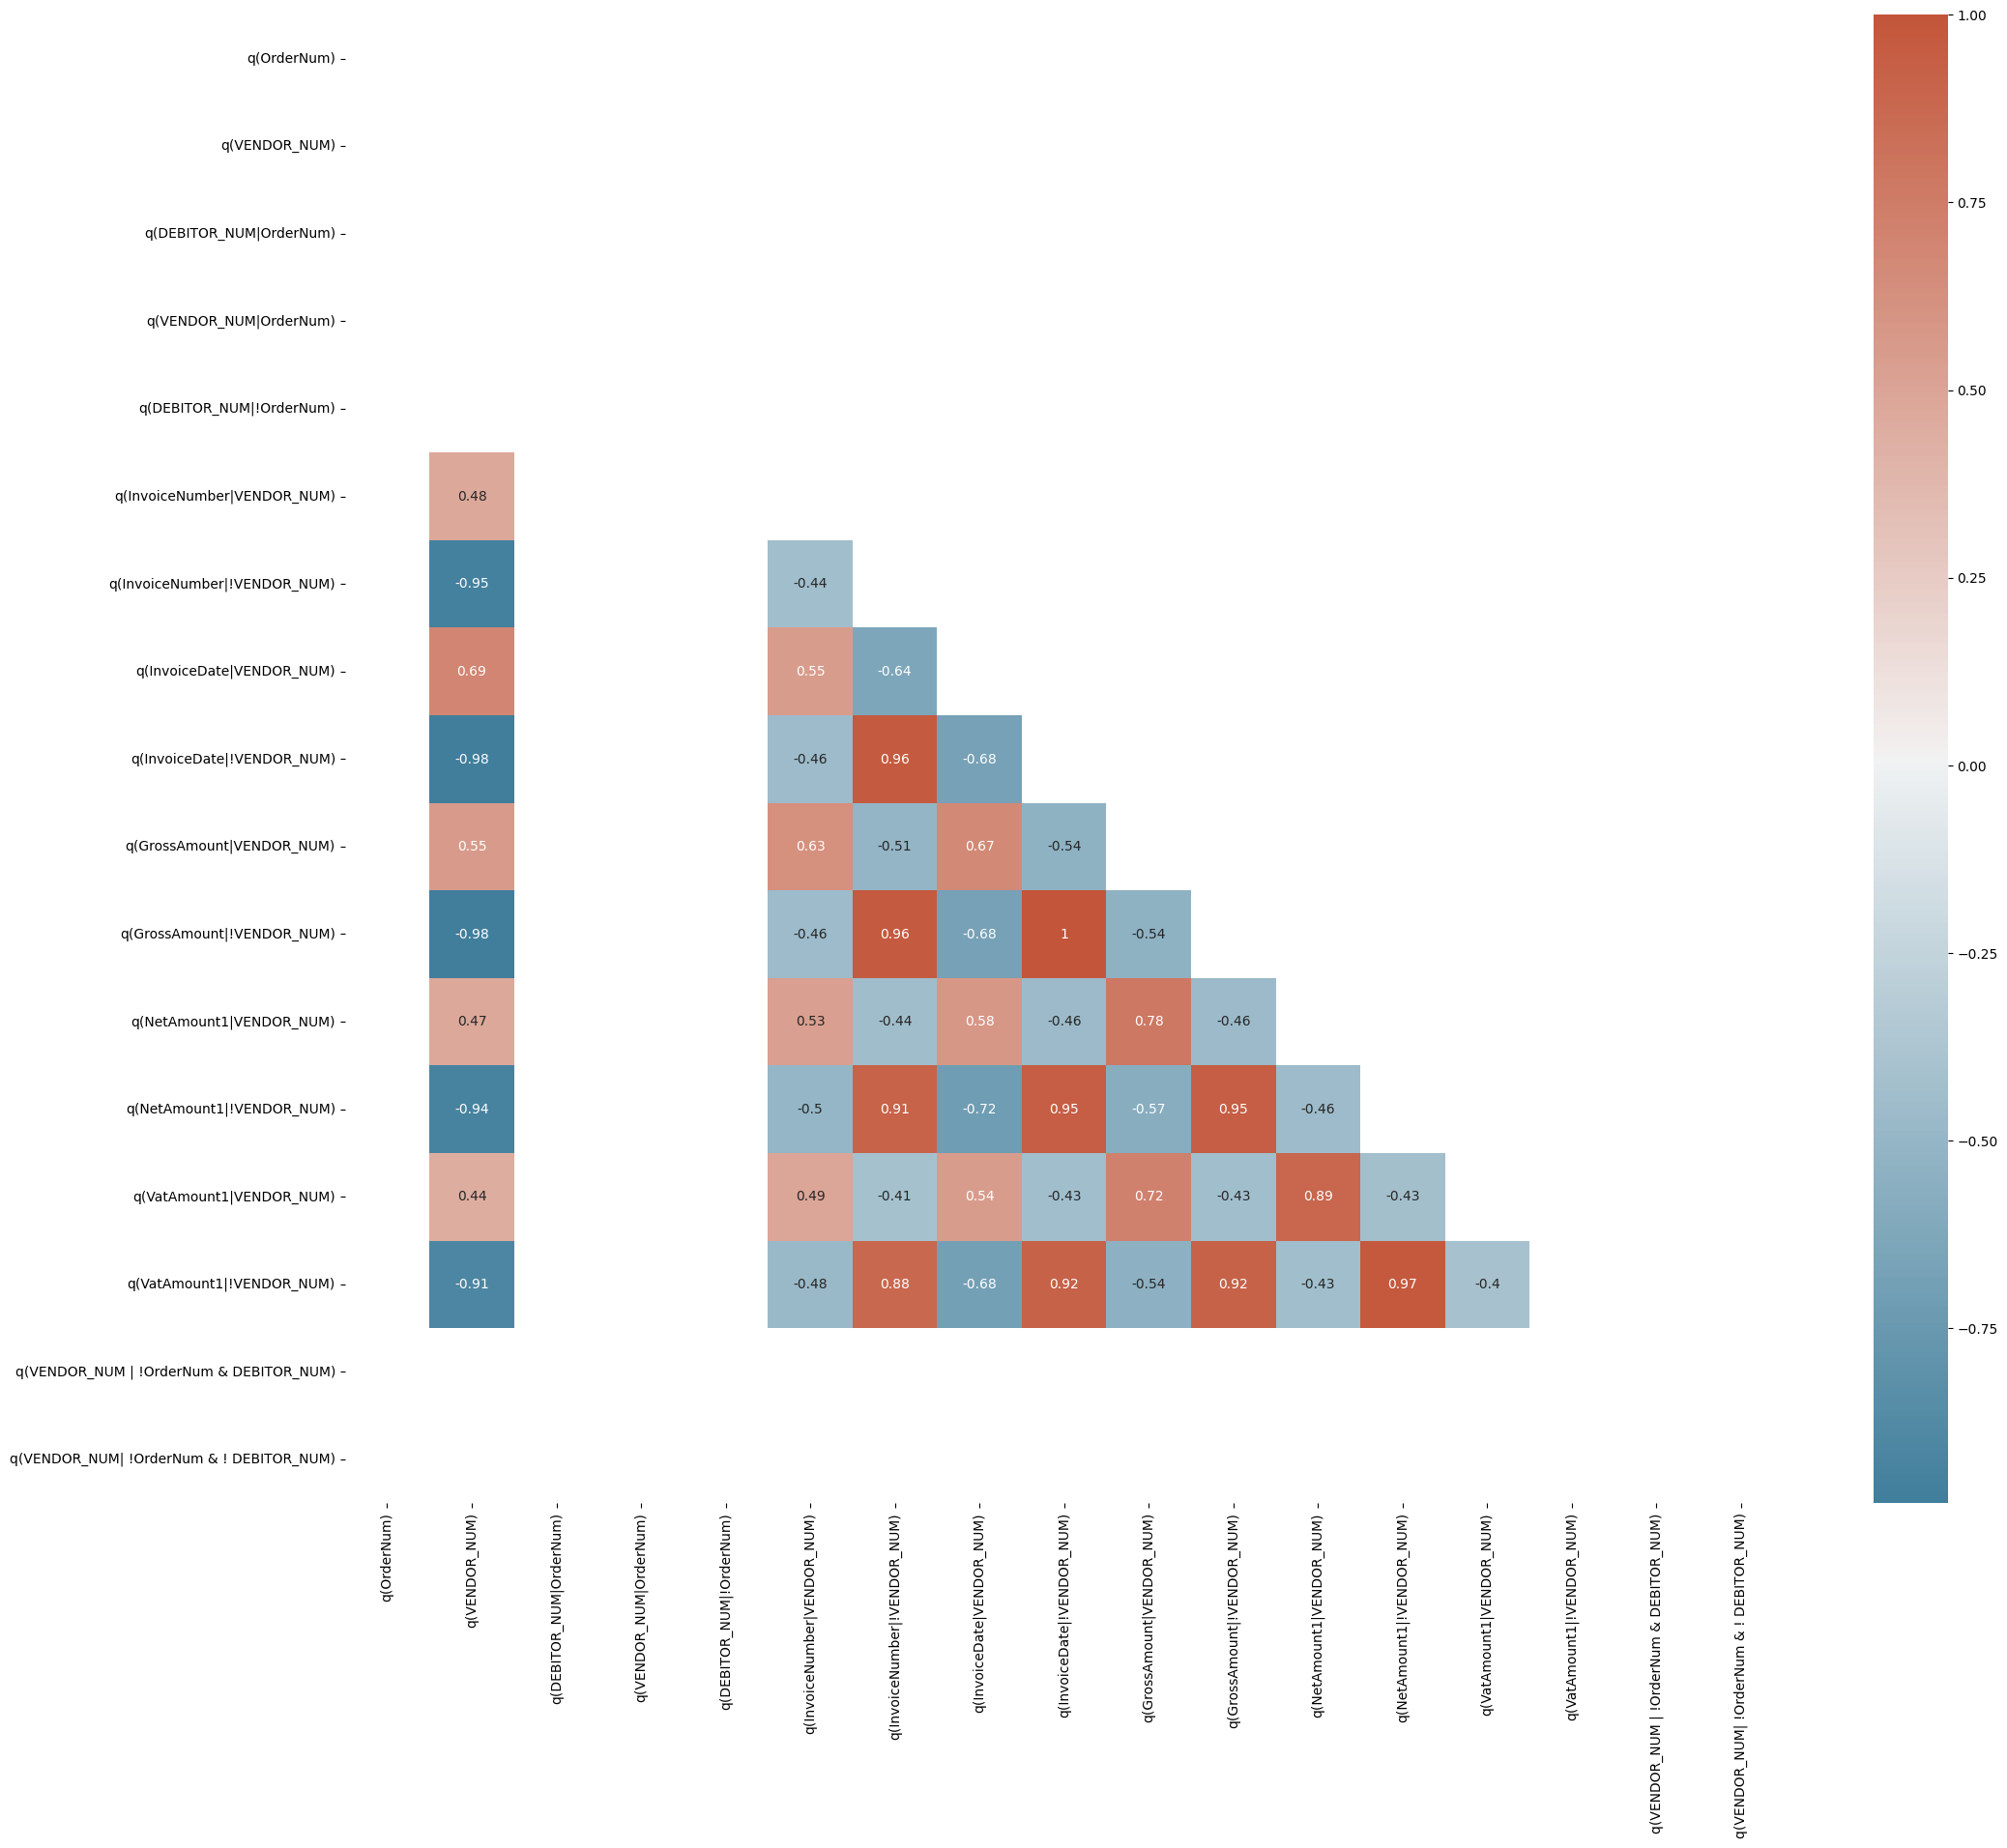

In [69]:
import scipy.stats
abc = df_table_cclogattributes.drop(['LogTime'], axis=1)
abc.fillna(0, inplace=True)
# inf_indices = np.isinf(abc)
# abc = abc[~inf_indices]
abc.replace([np.inf, -np.inf], np.nan, inplace=True)
abc.dropna(axis=0, how="all", inplace=True)

display(abc)

selected_values = ['DocumentType','DEBITOR_NUM','NAME','STR','ZIP','CITY','COUNTRY','VENDOR_NUM','VENDOR_NAME','VENDOR_STR','VENDOR_CITY','VENDOR_ZIP_CODE','VENDOR_IBAN','VENDOR_VAT_REGISTRATION_ID','InvoiceNumber','InvoiceDate','PerformanceDate','BookingDate','GrossAmountCurrency','GrossAmount','NetAmount1','VatRate1','VatAmount1','NetAmount2','VatRate2','VatAmount2','AdditionalCosts','ImpersonalAccount','CostCenter']
#get_data_values2(abc)
subset = result2[result2['Attribute_Name'].isin(selected_values)] 
subset['Attribute_Name'] = pd.Categorical(subset['Attribute_Name'], categories=selected_values, ordered=True)
grouped2 = subset.pivot_table(index='DocumentID', columns='Attribute_Name', values='Delta')

correlation_matrix = result.corr(method='kendall')

# spasodfi, asfdsadf = scipy.stats.spearmanr(result['q(VENDOR_NUM)'], result['q(NetAmount1|VENDOR_NUM)'])
# print(spasodfi, asfdsadf)
f, ax = plt.subplots(figsize=(24, 20))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


cmap = sns.diverging_palette(230, 20, as_cmap=True)


ax = sns.heatmap(correlation_matrix, annot=True, mask = mask, cmap=cmap)

ax.figure.savefig("data/correlation/dvelop.png")

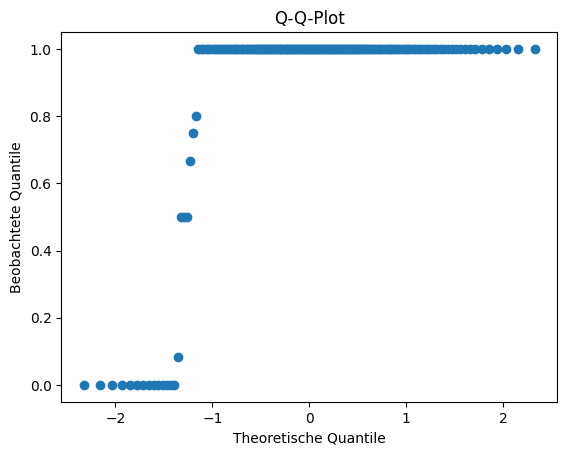

In [71]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

normalverteilung = np.random.normal(loc=0.5, scale=0.2, size=len(result['q(VENDOR_NUM)']))

sortierte_daten = np.sort(result['q(VENDOR_NUM)'])

quantile_normalverteilung = stats.norm.ppf(np.linspace(0.01, 0.99, len(result['q(VENDOR_NUM)'])))

plt.plot(quantile_normalverteilung, sortierte_daten, marker='o', linestyle='None')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Beobachtete Quantile') 
plt.title('Q-Q-Plot')
plt.show()


In [125]:
from PIL import Image

# Bilder laden
image1 = Image.open("data/correlation/brand.png").convert("RGBA")
image2 = Image.open("data/correlation/brand_mfw.png").convert("RGBA")
image3 = Image.open("data/correlation/dvelop.png").convert("RGBA")
image4 = Image.open("data/correlation/synaxon_SBO_EK4994_PROD.png").convert("RGBA")
image5 = Image.open("data/correlation/synaxon_SBO_SYN60986_PROD.png").convert("RGBA")
image6 = Image.open("data/correlation/vitronic.png").convert("RGBA")
# Transparenz hinzufügen
alpha = 0.3

images = [image1, image2, image3, image4, image5, image6]

# Transparenz hinzufügen und Bilder übereinanderlegen
alpha = 0.1
blended = Image.new("RGBA", images[0].size)
for image in images:
    blended = Image.alpha_composite(blended, image)

blended.show()



In [46]:
import pandas as pd


# Werte der relevanten Spalten auswählen
relevant_columns = ['Attribute_Before', 'Attribute_After', 'Delta', 'Type']
values = abc[relevant_columns]

# Korrelation berechnen
correlation_matrix = values.corr()

# Korrelationsmatrix ausgeben
print(correlation_matrix)


                  Attribute_Before  Attribute_After     Delta      Type
Attribute_Before          1.000000         0.669952 -0.001765 -0.001320
Attribute_After           0.669952         1.000000  0.001374  0.000357
Delta                    -0.001765         0.001374  1.000000  0.738622
Type                     -0.001320         0.000357  0.738622  1.000000


In [23]:
# Gruppieren und zählen der eindeutigen Kombinationen
# Berechnung der Korrelationswahrscheinlichkeit
from scipy.stats import pearsonr

# Korrelationsanalyse

# Datensatz einlesen
df = df_table_cclogattributes

df["Attribute_Before"] = pd.to_numeric(df["Attribute_Before"], errors="coerce")
df["Attribute_After"] = pd.to_numeric(df["Attribute_After"], errors="coerce")

# Entferne Zeilen mit NaN-Werten in den relevanten Spalten
df = df.dropna(subset=["Attribute_Before", "Attribute_After"])

# Korrelationsanalyse durchführen
correlation_data = []
for attribute_name in df["Attribute_Name"].unique():
    attribute_data = df[df["Attribute_Name"] == attribute_name]
    if len(attribute_data) > 1:
        correlation_coefficient, _ = pearsonr(attribute_data["Attribute_Before"], attribute_data["Attribute_After"])
        correlation_data.append({
            "Attribute_Name": attribute_name,
            "Correlation_Coefficient": correlation_coefficient
        })

# Ergebnisse ausgeben
correlation_df = pd.DataFrame(correlation_data)
print(correlation_df)

c:\Users\lete\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



                Attribute_Name  Correlation_Coefficient
0                          ZIP                      NaN
1                   NetAmount1            -3.510531e-07
2                     VatRate1             5.047778e-01
3                   VatAmount1            -5.979179e-04
4                   VENDOR_NUM             9.950565e-01
5              VENDOR_ZIP_CODE             9.961648e-01
6                  GrossAmount            -2.350388e-04
7                InvoiceNumber             9.472086e-01
8                     OrderNum             1.000000e+00
9                   NetAmount2             3.679460e-02
10                    VatRate2             7.690718e-01
11                  VatAmount2             3.701159e-02
12                  NetAmount3                      NaN
13                    VatRate3                      NaN
14                  VatAmount3                      NaN
15           ImpersonalAccount             7.522389e-01
16             AdditionalCosts             1.000

In [30]:
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Korrelationsanalyse mit Cramér's V-Koeffizient
correlation_data = []
for i in range(len(unique_entries)):
    entry_1 = unique_entries[i]
    entry_row_1 = df_table_cclogattributes[df_table_cclogattributes["Attribute_Name"] == entry_1]
    
    for j in range(i+1, len(unique_entries)):
        entry_2 = unique_entries[j]
        entry_row_2 = df_table_cclogattributes[df_table_cclogattributes["Attribute_Name"] == entry_2]
        
        if len(entry_row_1) > 0 and len(entry_row_2) > 0:
            # Kreuztabelle erstellen
            contingency_table = pd.crosstab(entry_row_1["Attribute_Before"], entry_row_2["Attribute_Before"])
            
            # Cramér's V-Koeffizient berechnen
            correlation_coefficient = cramers_v(contingency_table.values)
            
            correlation_data.append({
                "Attribute_Name_1": entry_1,
                "Attribute_Name_2": entry_2,
                "Correlation_Coefficient": correlation_coefficient
            })

# Ergebnisse ausgeben
correlation_df = pd.DataFrame(correlation_data)
print(correlation_df)

NameError: name 'unique_entries' is not defined

In [29]:
target_attributes = ["Attribute_Name", "Attribute_After"]
target_df = bc[bc["Attribute_Name"].isin(target_attributes)]

# Berechnen Sie die Korrelationen der Zielzeilen mit den anderen Zeilen in "Attribute After"
corr_with_target = target_df["Attribute_After"].corr(bc["Attribute_After"])
print(corr_with_target)


nan


# Machine Learning


## Data preprocessing

In [ ]:
df1 = pd.read_csv('data/cclogattributes_T0012hb.csv', encoding='iso-8859-15')

vergleiche_spalten = lambda x: 'master_data_error' if x['Attribute_Name'] == 'VENDOR_NUM' and x['Attribute_Before'] != x['Attribute_After'] else'good' if x['Delta'] == False and x['Type'] == 0 else 'undefined'
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_NAME' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_STR' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_CITY' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_ZIP_CODE' and x['Attribute_Before'] != x['Attribute_After'] \

df1['Suggestion'] = df1.apply(vergleiche_spalten, axis=1)

df1 = df1.drop('LogTimeTicks', axis=1)
#df = df.drop('DocumentID', axis=1)

df1.to_csv('data/after_preprocessing.csv', index=False, header= True, encoding='iso-8859-15')

X = df1.loc[ : , df1.columns != 'Suggestion']
Y = df1.loc[ : , df1.columns == 'Suggestion']


In [ ]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

#X = handle_non_numerical_data(X)


def Encoder(df):
          columnsToEncode = list(df.select_dtypes(include=['category','object','bool']))
          le = LabelEncoder()
          for feature in columnsToEncode:
              try:
                  df[feature] = le.fit_transform(df[feature])
              except:
                  print('Error encoding '+feature)
          return df


#Y = Encoder(Y)
#print(Y)
#pd.DataFrame(Y).to_csv("data/after_numerical.csv")


#print(X)
#X.shape[0]
#Y.shape[0]

In [ ]:
#Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=None, shuffle=False)

pd.DataFrame(y_train).to_csv("data/y_train.csv")

## Create Model and Train

In [ ]:
def create_model(optimizer='adam', init='uniform'):
    # create model
    if verbose: print("**Create model with optimizer: %s; init: %s" % (optimizer, init) )
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer=init, activation='relu')) #
    model.add(Dense(512, kernel_initializer=init, activation='relu'))
    model.add(Dense(256, kernel_initializer=init, activation='relu'))
    model.add(Dense(3, kernel_initializer=init, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adadelta(), metrics=['acc']) #keras.optimizers.Adadelta() and sparse_categorical_accuracy
    return model

In [ ]:
run_gridsearch = False

if run_gridsearch:
    
    start_time = time.time()
    if verbose: print (time.strftime( "%H:%M:%S " + "GridSearch started ... " ) )
    optimizers = ['rmsprop'] # , 'adam'
    inits = ['glorot_uniform'] #, 'normal', 'uniform'
    epochs = [5, 50, 100, 300]
    batches = [5, 32, 64]
    
    model = KerasClassifier(build_fn=create_model, verbose=verbose)
    
    param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    if verbose: 
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
        elapsed_time = time.time() - start_time  
        print ("Time elapsed: ",timedelta(seconds=elapsed_time))
        
    best_epochs = grid_result.best_params_['epochs']
    best_batch_size = grid_result.best_params_['batch_size']
    best_init = grid_result.best_params_['init']
    best_optimizer = grid_result.best_params_['optimizer']
    
else:
    # best paramters
    best_epochs = 300
    best_batch_size = 64
    best_init = 'glorot_uniform'
    best_optimizer = 'rmsprop'

In [ ]:
results_df = pd.DataFrame(grid_result.cv_results_)
pd.DataFrame(results_df).to_csv('data/grid_search_results.csv')
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [ ]:
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
ax.legend(loc=4, prop={'size': 6})

plt.show()


In [ ]:
model_pred = KerasClassifier(build_fn=create_model, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=verbose)
model_pred.fit(X_train, y_train)

prediction = model_pred.predict(X_test)

# Evaluation

In [ ]:
print(classification_report(y_test, prediction, zero_division=False))
accuracy_score(y_test, prediction)

In [ ]:
print(prediction)
pd.DataFrame(prediction).to_csv('data/prediction.csv')

In [ ]:
pickle.dump(model_pred, open('models/classification_model.h5', 'wb'))

In [ ]:
with open('models/classification_model.h5', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

prediction = content.predict(X_test)
print(classification_report(y_test, prediction, zero_division=False))


In [ ]:
import pyautogui
import time
while True:
    for i in range(0,100):
        pyautogui.moveTo(10,10)
        pyautogui.leftClick()
        pyautogui.moveTo(1000,1000)
        pyautogui.leftClick()

        time.sleep(2)